# Image Segmentation on BraTS 2D lesion-centered MRI scans

### Description of the original project
The original project demonstrates brain tumor segmentation from T1 MRI scans using deep learning techniques. The original dataset includes four modalities (T1, T2, T1ce, and FLAIR) for 1251 subjects, with three 2D sections per subject centered on the lesion barycenter. Each section is accompanied by a lesion mask serving as ground truth. The original implementation employed the MONAI and PyTorch frameworks with a UNet architecture but was limited in scope.
###Original Limitations
The initial model trained only on the T1 modality and a single slice per subject (slice 00). It lacked validation and test sets, data augmentation, dynamic hyperparameter adjustment, and employed a limited number of filters (max 64). Training used default hyperparameters, without leveraging a scheduler, and ran for a small number of epochs.
###Objective
The goal is to classify pathological tissues in MRI images while addressing these limitations by optimizing the training pipeline and exploring modality combinations.
###Methodology
We split the dataset into training, validation, and test sets. Based on literature and experimentation, we selected T1ce and FLAIR modalities for segmentation. Data augmentation was applied to expand the training dataset, along with transformations for consistency across datasets. Optuna was employed to optimize hyperparameters like learning rate and dropout. The UNet architecture was enhanced with an increased number of filters and a scheduler for learning rate adjustments. The model was trained on the training and validation sets and evaluated on the test set.
###Results
Our model achieved strong segmentation performance across metrics such as DiceCELoss, Dice metric, IoU, Precision, and Recall. Comparable results were obtained for slices 01 and 10. To balance computational efficiency, we retained a single slice (slice 00) for the final model. The improved methodology provides a robust approach for pathological tissue classification in MRI images.




## Imports

### Original work
Import the necessary packages.
### Changes performed
Differently from what already written in the code, we set seed for different libraries to make the code reproducible and obtain same results with different devices and runs. Import also Optuna, monai.losses and monai.metrics



In [ ]:
!pip install nilearn
!pip install monai
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import math
import pickle
import time
import matplotlib.pyplot as plt
import nilearn as nil
from nilearn.datasets import load_mni152_template
from nilearn import plotting
import nibabel as nib
import torch
from torch import nn
import torchvision
import monai
from monai.data import DataLoader, Dataset, CacheDataset, SmartCacheDataset
from monai.config import print_config
from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    EnsureChannelFirstd,
    Spacingd,
    OneOf,
    SomeOf,
    ScaleIntensityRanged,
    RandSpatialCropSamplesd,
    RandCoarseDropoutd,
    RandCoarseShuffled,
    RandSpatialCropd,
    RandAdjustContrastd,
    ResizeWithPadOrCropd,
    Resized,
    RandRotated,
    NormalizeIntensityd,
    ScaleIntensityRangePercentilesd,
    ScaleIntensityRangePercentiles,
    RandGaussianSmoothd,
    RandGaussianNoised,
    RandFlipd,
    RandCoarseDropoutd,
    RandKSpaceSpikeNoised,
    RandHistogramShiftd,
    RandGaussianSharpend,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    ResizeWithPadOrCropd,
    GaussianSmoothd,
    ConvertToMultiChannelBasedOnBratsClassesd,
    ConcatItemsd,
)

import optuna
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss, GeneralizedDiceLoss, GeneralizedDiceFocalLoss, GeneralizedWassersteinDiceLoss
from monai.metrics import DiceMetric, DiceHelper


# Set seed for reproducibility
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # if using GPU

## Data Paths

Because we are working in Google Colab, we placed our dataset in a zip file within the workspace. At the start of each session, we simply unzip this file and then use relative paths to load the data into our pipeline.

ATTENTION: In order to be able to run the code using Colab you should put the zip of BRATS_2D inside the following path in your google drive:
/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project12

If you execute the code in your computer change the BRATS_PATH and put in the same folder the BRATS_2D dataset.

In [ ]:
# mount Google Drive Folder
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project12"
REPO_PATH = os.getcwd()
BRATS_PATH = REPO_PATH + "/BRATS_2D/"
print(BRATS_PATH)


/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project12
/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project12/BRATS_2D/


In [ ]:
from zipfile import ZipFile

with ZipFile("BRATS_2D.zip", "r") as f:
    f.extractall("/content/")

In [ ]:
!ls /content

BRATS_2D  drive  __MACOSX  sample_data


In [ ]:
BRATS_PATH = "/content/BRATS_2D/"

In [ ]:
total_file_list = os.listdir(BRATS_PATH)
len(total_file_list)

18765

The filenames in the directory follow a specific convention.\
For inputs, the filename is:\
"SUBJECT{XXXX}_MODALITY{XX}_PLANE{XX}.npy"
\
For labels, the filename is:\
"SUBJECT{XXXX}_MASK_PLANE{XX}.npy"\
The label is valid for all modalities of the same subject and plane!

## Data Inspection

Let's load images from the first subject, subject 0.
We will load each view of each modality separately, and then combined in RGB-A format.

In [ ]:
subject_ID = 0
modalities = ["t1", "t2", "t1ce", "flair"]
planes = ["00", "01", "10"]

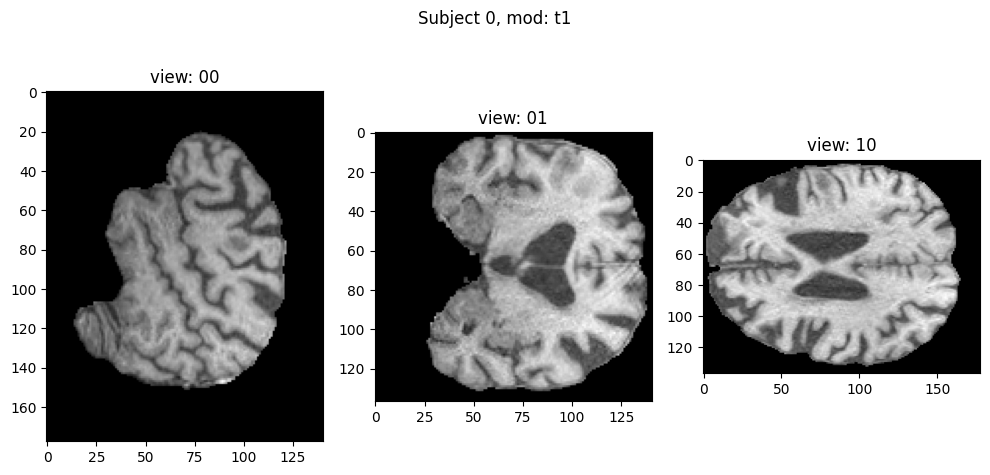

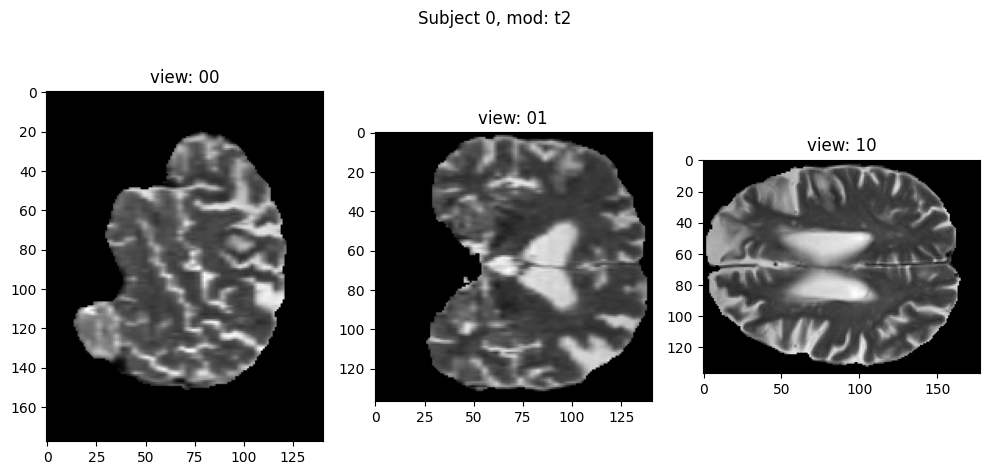

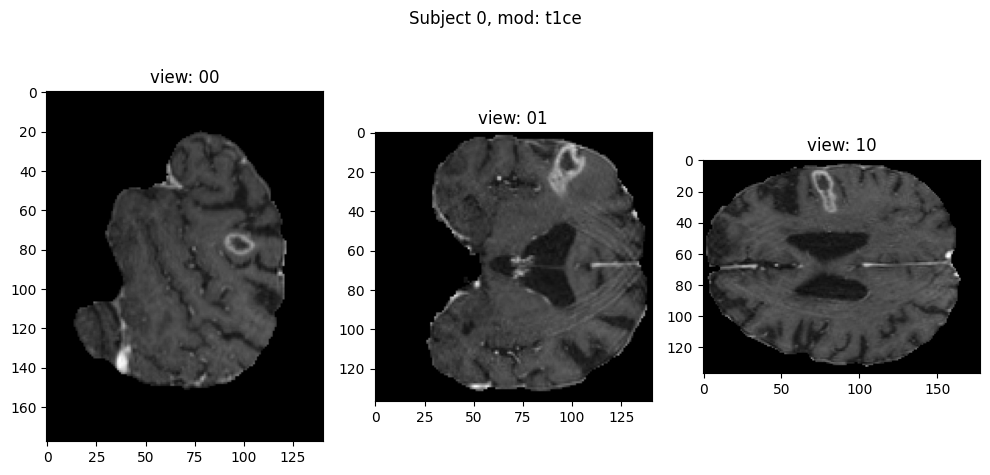

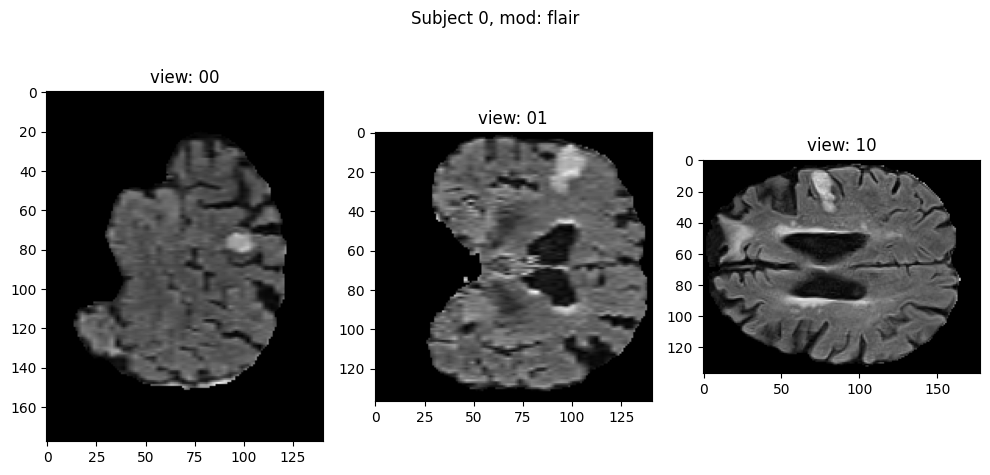

In [ ]:
# Only loading the images separately
# iterate over modalities
for modality in modalities:
    plt.figure(figsize=(10,5))
    # iterate over planes
    for i, plane in enumerate(planes):
        filename = f"SUBJECT{subject_ID}_MODALITY{modality}_PLANE{plane}.npy" # format string with {variables}

        # open the file with the correct name in the correct folder
        with open(BRATS_PATH+filename, 'rb') as file:
            image = np.load(file)
        plt.subplot(1,3,i+1)
        plt.imshow(image, cmap="gray")
        plt.title(f"view: {plane}")

    plt.suptitle(f"Subject {subject_ID}, mod: {modality}")
    plt.tight_layout()
    plt.show()
    plt.close()

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

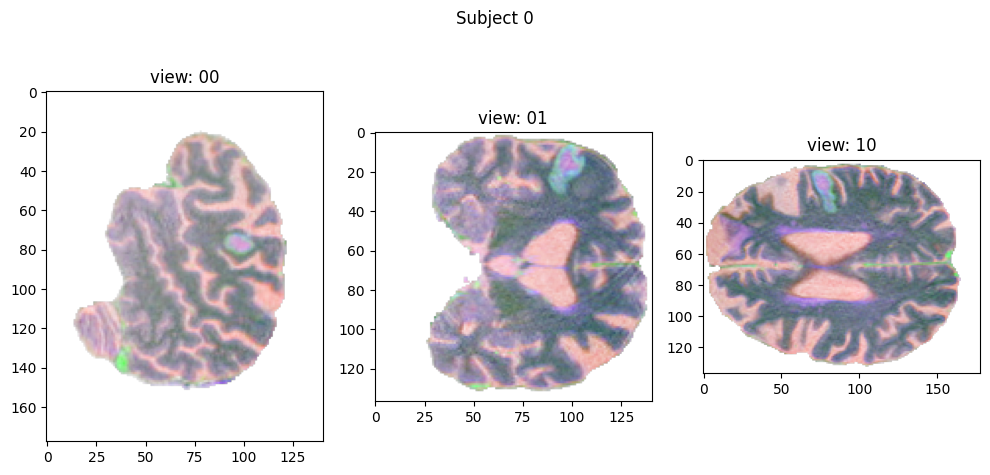

In [ ]:
# Loading images and combining them

# create a dictionary containing the modalities
image_dict = {}
for modality in modalities:
    plt.figure(figsize=(10,5))
    # iterate over planes
    # create a dictionary containing the planes
    image_dict[modality] = {}
    for i, plane in enumerate(planes):
        filename = f"SUBJECT{subject_ID}_MODALITY{modality}_PLANE{plane}.npy" # format string with {variables}

        # open the file with the correct name in the correct folder
        with open(BRATS_PATH+filename, 'rb') as file:
            image_dict[modality][plane] = np.load(file)
# now we have all planes for all modalities

plt.figure(figsize=(10,5))
for i, plane in enumerate(planes):
    plt.subplot(1,3,i+1)
    image = np.stack([image_dict["t2"][plane], image_dict["t1ce"][plane], image_dict["flair"][plane], image_dict["t1"][plane]])

    # the image has 4 channels (RGB-A), 1 for each modality, but plt.imshow() wants the channel dimension for last
    image = image.transpose(1,2,0)

    # min-max scaling in the channels, you can try standard scaling
    image = (image - np.min(image, axis=(0,1), keepdims=True)) / (np.max(image, axis=(0,1), keepdims=True) - np.min(image, axis=(0,1), keepdims=True))

    plt.imshow(image, cmap="gray")
    plt.title(f"view: {plane}")

plt.suptitle(f"Subject {subject_ID}")
plt.tight_layout()
plt.show()
plt.close()

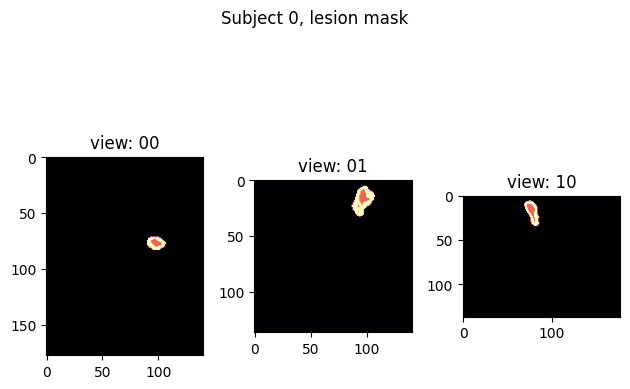

In [ ]:
for i, plane in enumerate(planes):
    filename = f"SUBJECT{subject_ID}_MASK_PLANE{plane}.npy" # format string with {variables}

    # open the file with the correct name in the correct folder
    with open(BRATS_PATH+filename, 'rb') as file:
        image = np.load(file)
    plt.subplot(1,3,i+1)

    # the tissue class is 0 or 1, for every channel, channel is the first dimension,
    # we first put the channel dimension last, and then we sum the lesion classes to obtain the tumor region class
    image = image.transpose(1,2,0).sum(axis=-1)
    plt.imshow(image, cmap="magma")
    plt.title(f"view: {plane}")

plt.suptitle(f"Subject {subject_ID}, lesion mask")
plt.tight_layout()
plt.show()
plt.close()

## Training, validation and test sets definition

### Split data
### Original work

In the original work, the entire dataset was used as the training data, focusing exclusively on the T1 modality and selecting only the slice corresponding to plane 00.

### Changes performed
Firstly we divided the dataset into training, validation and test sets. In this case, since we had only one dataset, the test set has been extracted from the same dataset used for training and validation phases, ensuring that samples considered for the test were different from those used for the other procedures.
Moreover, to increase model reliability and results validity, we shuffled subjects to make them not-ordered following subject number.

Then we created a function that generated split datasets using all four modalities (T1, T2, T1ce and flair).

N.B: The function works only for a plane at a time.

In [ ]:
TRAIN_PATH = BRATS_PATH

######################
# DATASET DEFINITION #
######################

# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Total subjects
subjects_ID_list = list(range(1251))

# Shuffle subjects
random.shuffle(subjects_ID_list)

# Compute split indices
train_count = int(train_ratio * len(subjects_ID_list))
val_count = int(val_ratio * len(subjects_ID_list))

# Split subjects
train_subjects = subjects_ID_list[:train_count]
val_subjects = subjects_ID_list[train_count:train_count + val_count]
test_subjects = subjects_ID_list[train_count + val_count:]

print(f"Training subjects: {len(train_subjects)}")
print(f"Validation subjects: {len(val_subjects)}")
print(f"Test subjects: {len(test_subjects)}")

# function to generate data for each split
# Using only the plane 00
def generate_split_data(subjects):
    brains_t1_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt1_PLANE{'00'}.npy" for subject in subjects]
    brains_t2_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt2_PLANE{'00'}.npy" for subject in subjects]
    brains_t1ce_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt1ce_PLANE{'00'}.npy" for subject in subjects]
    brains_flair_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYflair_PLANE{'00'}.npy" for subject in subjects]
    masks_t = [TRAIN_PATH+f"SUBJECT{subject}_MASK_PLANE{'00'}.npy" for subject in subjects]

    return [
        {
            "image_t1": brain_t1,
            "image_t2": brain_t2,
            "image_t1ce": brain_t1ce,
            "image_flair": brain_flair,
            "mask": mask,
        }
        for brain_t1, brain_t2, brain_t1ce, brain_flair, mask in zip(
            brains_t1_t, brains_t2_t, brains_t1ce_t, brains_flair_t, masks_t
        )
    ]

# Generate datasets
train_data = generate_split_data(train_subjects)
val_data = generate_split_data(val_subjects)
test_data = generate_split_data(test_subjects)

print(f"Train Data: {len(train_data)} samples")
print(f"Validation Data: {len(val_data)} samples")
print(f"Test Data: {len(test_data)} samples")

print(train_subjects)
print(train_data)



print(train_data[3]["image_t1"])



Training subjects: 875
Validation subjects: 250
Test subjects: 126
Train Data: 875 samples
Validation Data: 250 samples
Test Data: 126 samples
[1001, 1216, 1248, 889, 923, 739, 1226, 382, 855, 614, 107, 32, 1048, 512, 1117, 195, 654, 829, 587, 356, 808, 950, 804, 192, 1135, 526, 261, 647, 35, 622, 868, 772, 461, 1233, 276, 809, 49, 989, 348, 797, 179, 1005, 502, 861, 1045, 66, 1207, 294, 1214, 383, 787, 712, 724, 504, 298, 624, 731, 434, 1060, 463, 1095, 1019, 100, 1097, 428, 751, 599, 1020, 241, 1236, 508, 726, 21, 617, 891, 662, 55, 220, 1006, 783, 721, 768, 1024, 346, 942, 671, 794, 419, 1032, 536, 1072, 289, 263, 1129, 1187, 454, 187, 805, 895, 337, 632, 1237, 529, 202, 18, 210, 732, 562, 67, 515, 56, 332, 1181, 969, 975, 963, 916, 840, 1075, 4, 588, 1107, 557, 728, 361, 259, 792, 1121, 445, 121, 81, 11, 214, 991, 164, 960, 800, 367, 633, 1141, 1036, 462, 246, 709, 1012, 537, 844, 898, 485, 148, 427, 857, 286, 697, 742, 395, 87, 352, 643, 17, 34, 1038, 153, 212, 668, 347, 1014, 998

### Transformations and augmentations for training, validation, and testing

### Original work
They used the Compose function to create a streamlined data preprocessing pipeline that ensures consistency, efficiency, and readiness of the dataset for model training. Within this pipeline, CropForegroundd was applied using the T1 image as the source key to automatically crop out irrelevant background regions and focus on the region of interest. The Spacingd transform was used to resample the images and masks to a uniform pixel spacing of 1x1x1, ensuring consistent resolution across the dataset. Finally, SpatialPadd was applied to symmetrically pad the images and masks to a fixed size of 256x256, meeting the model's input dimensional requirements.
### Changes perfomed

In this notebook, we used the Compose function to streamline preprocessing for all three datasets. Only T1ce and FLAIR modalities were included, with source_key set to "image_t1ce" in CropForegroundd to focus on the region of interest.

For the training set, we added data augmentations such as random flips, Gaussian noise, brightness adjustments and zoom. Other augmentations like elastic deformations and rotations were tested but commented out due to limited improvement.

Validation and test sets were processed with cropping, resizing, padding, and normalization, but no augmentations were applied to ensure consistent evaluation.

In [ ]:
# modality_keys = ["image_t1", "image_t2", "image_t1ce", "image_flair"]
modality_keys = ["image_t1ce", "image_flair"]

from monai.transforms import RandZoomd
from monai.transforms import Rand2DElasticd

# training set transformations
# try to add more modalities
train_transforms = Compose([
        LoadImaged(keys = modality_keys +  ["mask"]),
        EnsureChannelFirstd(keys=modality_keys),
        CropForegroundd(keys=modality_keys +  ["mask"], source_key="image_t1ce"), # with 4 modalities, t1 is used
        ConcatItemsd(keys=modality_keys, name="image"),
        Spacingd(keys=["image", "mask"], pixdim=(1,1,1), mode=("trilinear", "trilinear")), #Try trilinear and nearest
        SpatialPadd(keys=["image", "mask"], spatial_size=(256,256), method="symmetric", mode="constant"),
        # Normalization of the data
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),

    RandFlipd(
        keys=["image", "mask"],
        spatial_axis=[0],  # Flip along x-axis
        prob=0.5,
    ),
    RandGaussianNoised(
        keys=["image"],
        mean=0.0,
        std=0.1,
        prob=0.2,),

    RandAdjustContrastd( # Random brightness adjustment
    keys=["image"],
    prob=0.3,
    gamma=(0.7, 1.5),
    ),

    RandZoomd(
    keys=["image", "mask"],
    min_zoom=0.9,
    max_zoom=1.1,
    prob=0.3,
    mode=("trilinear", "nearest"),
    ),

    # Rotation
    # RandRotated(
    # keys=["image", "mask"],
    # range_x=np.pi/6,
    # range_y=np.pi/6,
    # prob=0.3,
    # mode=("bilinear", "nearest"),
    #),

    # Elastic deformation
    #Rand2DElasticd(
    #    keys=["image", "mask"],
    #    spacing=(10, 10),
    #    magnitude_range=(1, 2),   # Range of deformation magnitudes
    #    prob=0.3,                 # Probability of applying deformation
    #    rotate_range=(0.1, 0.1),  # Random rotation (in radians)
    #    shear_range=(0.1, 0.1),   # Random shearing
    #    mode=("bilinear", "nearest"),  # Interpolation mode
    #),
])

# validation set transformations
val_transforms = Compose([
        LoadImaged(keys = modality_keys +  ["mask"]),
        EnsureChannelFirstd(keys=modality_keys),
        CropForegroundd(keys=modality_keys +  ["mask"], source_key="image_t1ce"), # with 4 modalities, t1 is used
        ConcatItemsd(keys=modality_keys, name="image"),
        Spacingd(keys=["image", "mask"], pixdim=(1,1,1), mode=("trilinear", "trilinear")), #Try trilinear and nearest
        SpatialPadd(keys=["image", "mask"], spatial_size=(256,256), method="symmetric", mode="constant"),
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),

])

# test set transformations
test_transforms = Compose([
        LoadImaged(keys = modality_keys +  ["mask"]),
        EnsureChannelFirstd(keys=modality_keys),
        CropForegroundd(keys=modality_keys +  ["mask"], source_key="image_t1ce"),
        ConcatItemsd(keys=modality_keys, name="image"),
        Spacingd(keys=["image", "mask"], pixdim=(1,1,1), mode=("trilinear", "trilinear")), #Try trilinear and nearest
        SpatialPadd(keys=["image", "mask"], spatial_size=(256,256), method="symmetric", mode="constant"),
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),

])

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


### Selection of modalities and dataset check

### Original work
They creates a dataset (check_ds) using the training data and the defined train_transforms, then loads it into a DataLoader for batch processing. A single sample is fetched to verify the preprocessing pipeline, ensuring that the image and mask shapes are correct before proceeding with training.

### Changes performed
The first two code lines allows to select the modalities to use for the training of the model. From what we saw through different trials, papers and images visualization and inspection, we decided to use for our model only T1ce and flair image types, since they showed to be the ones that works better: as said also in the abstract, the acquisition modality used (e.g. the use of contrast agent) in these two techniques makes the model perform better in this specific task.

In [ ]:
 selectedModalities_train_data = [
    {"image_t1ce": item["image_t1ce"], "image_flair": item["image_flair"], "mask": item["mask"]}
    for item in train_data
]

selectedModalities_val_data = [
    {"image_t1ce": item["image_t1ce"], "image_flair": item["image_flair"], "mask": item["mask"]}
    for item in val_data
]

selectedModalities_test_data = [
    {"image_t1ce": item["image_t1ce"], "image_flair": item["image_flair"], "mask": item["mask"]}
    for item in test_data
]


check_ds = Dataset(data=selectedModalities_train_data, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, num_workers=1)


# Check the the dataset loaded
from monai.utils import first
check_data = next(iter(check_loader))
image = check_data["image"]
label = check_data["mask"]
print(f"image shape: {image.shape}")
print(f"mask shape: {label.shape}")
print(check_data.keys())
print(f"Image value range: {image.min().item()} to {image.max().item()}")


image shape: torch.Size([1, 2, 256, 256])
mask shape: torch.Size([1, 3, 256, 256])
dict_keys(['image_t1ce', 'image_flair', 'mask', 'foreground_start_coord', 'foreground_end_coord', 'image'])
Image value range: -2.6290924549102783 to 7.319464206695557


Data are loaded with shape (B, C, H, W), B: batch size; C: channels; H: height; W: width

## Data Class and Data Loader



This code defines a DataLoader with a batch size of 32 and uses a custom collate function to symmetrically pad batches when BATCH_SIZE > 1.

In [ ]:
# Define DataLoader using MONAI, CacheDataset needs to be used
# from monai.data.utils import pad_list_data_collate
BATCH_SIZE = 32
if BATCH_SIZE > 1:
        def collate_fn(batch):
            return monai.data.utils.pad_list_data_collate(batch, method="symmetric", mode="replicate")

### DataLoader setup for training, validation, and testing

### Original work
They creates a dataset (train_ds) using the training data and the defined train_transforms, then loads it into a DataLoader for batch processing with a BATCH_SIZE of 32.

### Changes performed
Since both validation and test datasets have been defined from the original dataset, we added Dataset and DataLoader also for these two groups. Moreover, we checked from training dataset that batches have the correct size of 32.



In [ ]:
# Training DataLoader
train_ds = Dataset(data=selectedModalities_train_data, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)

# Check that batches have size of 32
from monai.utils import first
check_data = next(iter(train_loader))
image = check_data["image"]
label = check_data["mask"]
print(f"image shape: {image.shape}")
print(f"mask shape: {label.shape}")

# Validation DataLoader
val_ds = Dataset(data=selectedModalities_val_data, transform=val_transforms)
val_loader = DataLoader(val_ds,batch_size=1, num_workers=1)

# Test DataLoader
test_ds = Dataset(data=selectedModalities_test_data, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=1)


image shape: torch.Size([32, 2, 256, 256])
mask shape: torch.Size([32, 3, 256, 256])


### Setting the device

### Original work
Set the device to use GPU if available, otherwise CPU is used.

### Changes performed
Add the possibility to use GPU on Macbook using MPS.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

print(device)

cuda:0


## Hyperparameters tuning using Optuna



### Changes performed
Optuna is an automatic hyperparameter tuning designed for machine learning that allows to properly find the best hyperparameter configuration for our model. The model defined into the objective function is a UNet model with two input channels (corresponding to the two image types) and three output layers (corresponding to the three label classes), PReLU activation function, INSTANCE normalization (normalize only input data), kernel of 3 and stride of 2. Model have been tuned considering different possible number of filters.

The hyperparameters to tune are: learning rate and dropout.
Hyperparameters could vary between 1e-4 and 1e-2 for learning rate, and between 0 and 0.5 for dropout. The code outputs the best hyperparameters value.

Also other models with 4 inputs and different architecture (attentionUNet and batch normalization) have been tested.

**Pay attention that it is not necessary to run this section!**

The optimal hyperparameters values have already been found and saved into a variable to be used in the following sections. If it is necessary to run this part, we must notify that it is time consuming.

In [ ]:

###################################################
#           Define the Optuna objective
###################################################
def objective(trial):
    """
    This function is called by Optuna. It samples hyperparameters,
    builds the model and trains it for a fixed number of epochs.
    We return the validation loss (or any other metric) that we want to minimize.
    """

    # 1) Suggest hyperparameters (example: learning rate, dropout)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)

    # 2) Define model
    '''model = monai.networks.nets.UNet(spatial_dims=2, in_channels=4, out_channels=3, channels=[16,32,64,128,256,512],
                                 strides=[2,2,2,2,2], kernel_size=3, up_kernel_size=3,
                                 act='PRELU', norm='INSTANCE',
                                 dropout=dropout, bias=True).to(device)''' # with all 4 modalities

    model = monai.networks.nets.UNet(spatial_dims=2, in_channels=2, out_channels=3, channels=[16,32,64,128,256,512],
                                 strides=[2,2,2,2,2], kernel_size=3, up_kernel_size=3,
                                 act='PRELU', norm='INSTANCE',
                                 dropout=dropout, bias=True).to(device) # with only 2 modalities

    '''model = monai.networks.nets.AttentionUnet(spatial_dims = 2, in_channels = 2, out_channels = 3, channels=[16, 32, 64, 128, 256],
                                strides = [2,2,2,2,2], kernel_size=3, up_kernel_size=3,
                                 dropout=dropout).to(device)''' # model using attentionUNet

    '''model = monai.networks.nets.UNet(spatial_dims=2, in_channels=2, out_channels=3, channels=[16,32,64,128,256,512],
                                 strides=[2,2,2,2,2], kernel_size=3, up_kernel_size=3,
                                 act='PRELU', norm='BATCH',
                                 dropout=dropout, bias=True).to(device)''' # with only 2 modalities and Batch Normalization


    # 3) Define loss function, optimizer, scheduler, etc.
    loss_function = DiceCELoss(lambda_ce=0.5, sigmoid=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           mode="min",
                                                           factor=0.5,
                                                           patience=3,
                                                           verbose=False)

    # 4) Training loop: do fewer epochs to keep it fast
    max_epochs_for_optuna = 10  # fewer epochs than final training
    epoch_loss = 0
    steps = 0
    val_loss = 0
    val_steps = 0

    for epoch in range(max_epochs_for_optuna):
        model.train()

        for batch_data in train_loader:
            steps += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["mask"].to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= steps

        # Validation after each epoch
        model.eval()

        with torch.no_grad():
            for val_data_batch in val_loader:
                val_steps += 1
                val_inputs = val_data_batch["image"].to(device)
                val_labels = val_data_batch["mask"].to(device)

                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_labels).item()

        val_loss /= val_steps
        scheduler.step(val_loss)  # update LR scheduler

        # (Optional) Prune unpromising trials
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss  # we want to minimize val_loss

################################
#     Run the Optuna Study
################################
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # number of trials; adjust as needed

print("Number of finished trials:", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Loss:", best_trial.value)
print("  Params:", best_trial.params)

# Number of finished trials: 20
# Best trial:
#   Loss: 0.027137137609182144
#   Params: {'lr': 0.005394151833831802, 'dropout': 0.1}

[I 2025-01-05 13:58:54,316] A new study created in memory with name: no-name-e6f01b3d-fd28-4fc4-a152-086db9f477a5
[I 2025-01-05 14:07:19,222] Trial 0 finished with value: 0.09506897945701717 and parameters: {'lr': 0.00010147893961235425, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.09506897945701717.
[I 2025-01-05 14:15:35,190] Trial 1 finished with value: 0.09467040667374434 and parameters: {'lr': 0.00015628199660461454, 'dropout': 0.5}. Best is trial 1 with value: 0.09467040667374434.


## Model definition

### Original work
The original code defines a 2D U-Net model with a single input channel and three output channels, using three levels of feature extraction (channels=[16, 32, 64]) and downsampling strides of 2. It uses PReLU activation, instance normalization, and a 10% dropout rate for regularization.

### Changes perfomed
We increased the number of input channels (from 1 modality to 2). The selected dropout to define the model is the one found via Optuna.

The final model for the training phase is a UNet model with two input channels and three output layers, stride of 2, kernel of 3 and value of dropout as the one found during the tuning phase.

Also other models have been considered: one with all 4 modalities as input, one built as attentionUNet, another with UNetR and the last one with Batch Normalization. All of them have returned lower performances w.r.t the ones of the purposed model, and were most of them more computationally expensive.

In [ ]:
#best_lr = best_trial.params["lr"]
#best_dropout = best_trial.params["dropout"]

## Use the following parameters returned by Optuna choosing the right slice

# Slice 00
best_lr = 0.0038531818838573157
best_dropout = 0.1

# Slice 01
#best_lr = 0.006363769782566793
#best_dropout = 0.1

# Slice 10
#best_lr = 0.008543678652872186
#best_dropout = 0.1

print(f"Best learning rate: {best_lr}")
print(f"Best dropout: {best_dropout}")

'''model = monai.networks.nets.UNet(spatial_dims=2, in_channels=4, out_channels=3, channels=[16,32,64,128,256,512],
                                 strides=[2,2,2,2,2], kernel_size=3, up_kernel_size=3,
                                 act='PRELU', norm='INSTANCE',
                                 dropout=best_dropout, bias=True)'''


model = monai.networks.nets.UNet(spatial_dims=2, in_channels=2, out_channels=3, channels=[16,32,64,128,256,512],
                                 strides=[2,2,2,2,2], kernel_size=3, up_kernel_size=3,
                                 act='PRELU', norm='INSTANCE',
                                 dropout=best_dropout, bias=True) # with only selected modalities

'''model = monai.networks.nets.UNETR(spatial_dims=2, in_channels=2, out_channels=3,
                                     img_size=(256, 256),
                                     feature_size=16,
                                     hidden_size=144,
                                     mlp_dim=3072, num_heads=12,
                                     norm_name="instance",
                                     res_block = True,
                                     dropout_rate=best_dropout,
                                     )''' # with only selected modalities and UNETR, too computationally expensive

'''model = monai.networks.nets.AttentionUnet(spatial_dims = 2, in_channels = 2, out_channels = 3, channels = [16, 32, 64, 128, 256],
                                strides = [2,2,2,2,2], kernel_size=3, up_kernel_size=3,
                                 dropout=best_dropout)''' # with only selected modalities and AttentionUnet

'''model = monai.networks.nets.UNet(spatial_dims=2, in_channels=2, out_channels=3, channels=[16,32,64,128,256,512],
                                 strides=[2,2,2,2,2], kernel_size=3, up_kernel_size=3,
                                 act='PRELU', norm='BATCH',
                                 dropout=best_dropout, bias=True)''' # with only selected modalities and Batch Normalization

Best learning rate: 0.0038531818838573157
Best dropout: 0.1


"model = monai.networks.nets.UNet(spatial_dims=2, in_channels=2, out_channels=3, channels=[16,32,64,128,256,512],\n                                 strides=[2,2,2,2,2], kernel_size=3, up_kernel_size=3,\n                                 act='PRELU', norm='BATCH',\n                                 dropout=best_dropout, bias=True)"

In [ ]:
def count_pms(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_pms(model) # Look at the number of the parameters

2652013

## Define Training recipe

### Original work

This code sets up the training configuration with a learning rate of 0.001, 20 epochs, and a DiceCELoss loss function combining Dice and Cross-Entropy losses with a sigmoid activation. The DiceMetric is used to evaluate segmentation performance and the Adam optimizer is initialized for model training. The device is set to GPU if available, otherwise CPU.

### Changes performed
Firstly we increased the number of epochs to 50 to let the model stabilize more properly. As optimizer we used Adam as it has the best performances.

Also other optimization algorithms have been considered, as AdaBelief, SGD Adagrad but then discarded as returned lower performanced w.r.t the selected one.

We added the scheduler to change the learning rate value when there is a plateau in the performances, by multiplying it by 0.5 after 5 epochs of non-improvement.

A possibile option should be to add an early stopper, in this case discarded as the model train can be stopped manually when it doesn't improve anymore.

In [ ]:
max_epochs = 50
# DiceCELoss compute both Dice loss and Cross Entropy Loss, and return the weighted sum of these two losses.

loss_function = DiceCELoss(lambda_ce=0.5, sigmoid=True)
dice_metric = DiceMetric(include_background=True, reduction="mean") # Setting include_background=True means the Dice score will also consider the background class (non-tumor regions).
optimizer = torch.optim.Adam(model.parameters(), best_lr)


# Use AdaBelief optimizer
'''
optimizer = AdaBelief(
    model.parameters(),
    lr=best_lr,
    eps=1e-16,
    betas=(0.9, 0.999),
    weight_decay=1e-2,  # Optional L2 regularization
    rectify=True
)
'''

# SGD optimizer
'''optimizer = SGD(model.parameters(), lr=best_lr, momentum=0.9, weight_decay=1e-2)'''

# Adagrad optimizer
'''optimizer = Adagrad(model.parameters(), lr=best_lr, weight_decay=1e-4, lr_decay=0.01, initial_accumulator_value=0, eps=1e-10)'''



# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",  # Minimizing the validation loss
    factor=0.5,  # Multiply LR by 0.5 when triggered
    patience=5,  # Wait 5 epochs with no improvement
    verbose=True  # Print updates when LR is adjusted
)

# from monai.handlers import EarlyStopHandler
# early_stopper = EarlyStopHandler(patience=10, score_function=lambda engine: engine.state.metrics["dice_metric"])



## Model Training

### Original work
This code trains the model over multiple epochs, recording the average loss and Dice score for each epoch. It evaluates a random training sample at the end of each epoch, visualizing the input image, predicted mask, and ground truth. The loop also stores metrics for tracking performance over time.

### Changes performed
The model has been trained on training set and loss has been computed for both training and validation sets, to evaluate the model performances on both datasets.

Best model parameters have been saved in the "/BestModel" path.

In [ ]:
model.to(device)
print(next(model.parameters()).device)

cuda:0


----------
epoch 1/50
epoch 1 average loss: 0.9564
current epoch: 1 train_set mean dice: 0.1665
time consuming of epoch 1 is: 47.0804
epoch 1 average validation loss: 0.9215
Best model saved with validation loss: 0.9215
Current Learning Rate: 0.0038531818838573157


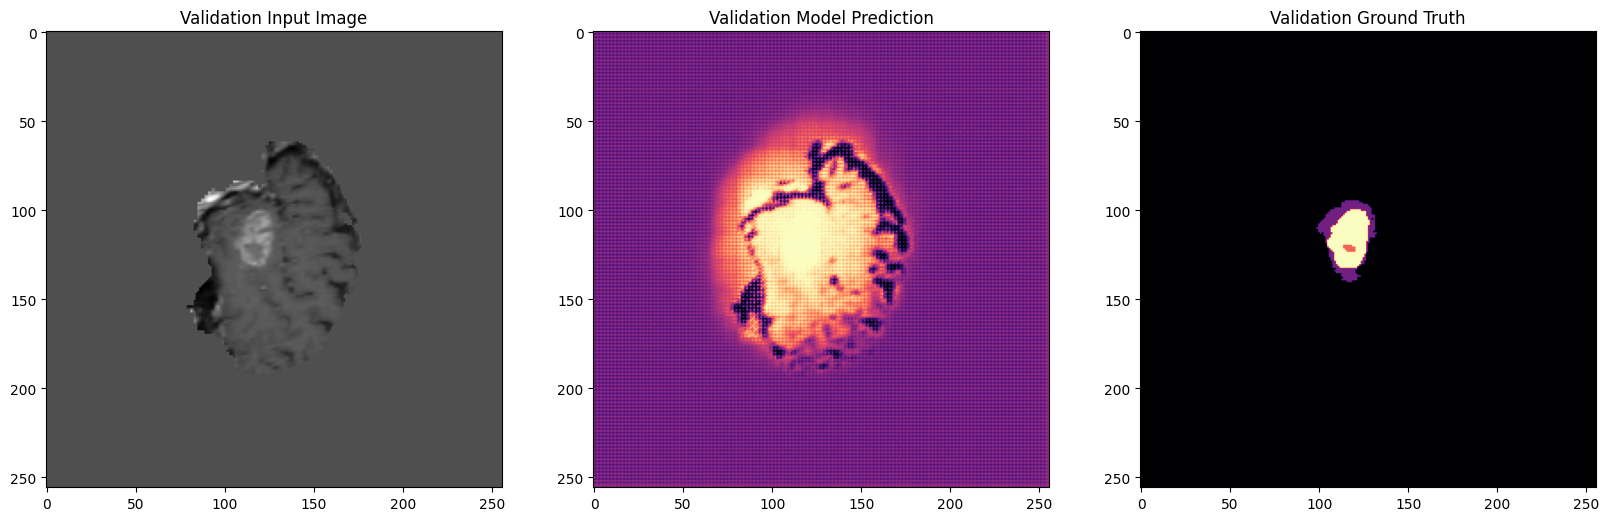

----------
epoch 2/50
epoch 2 average loss: 0.8935
current epoch: 2 train_set mean dice: 0.3193
time consuming of epoch 2 is: 41.7116
epoch 2 average validation loss: 0.8513
Best model saved with validation loss: 0.8513
Current Learning Rate: 0.0038531818838573157


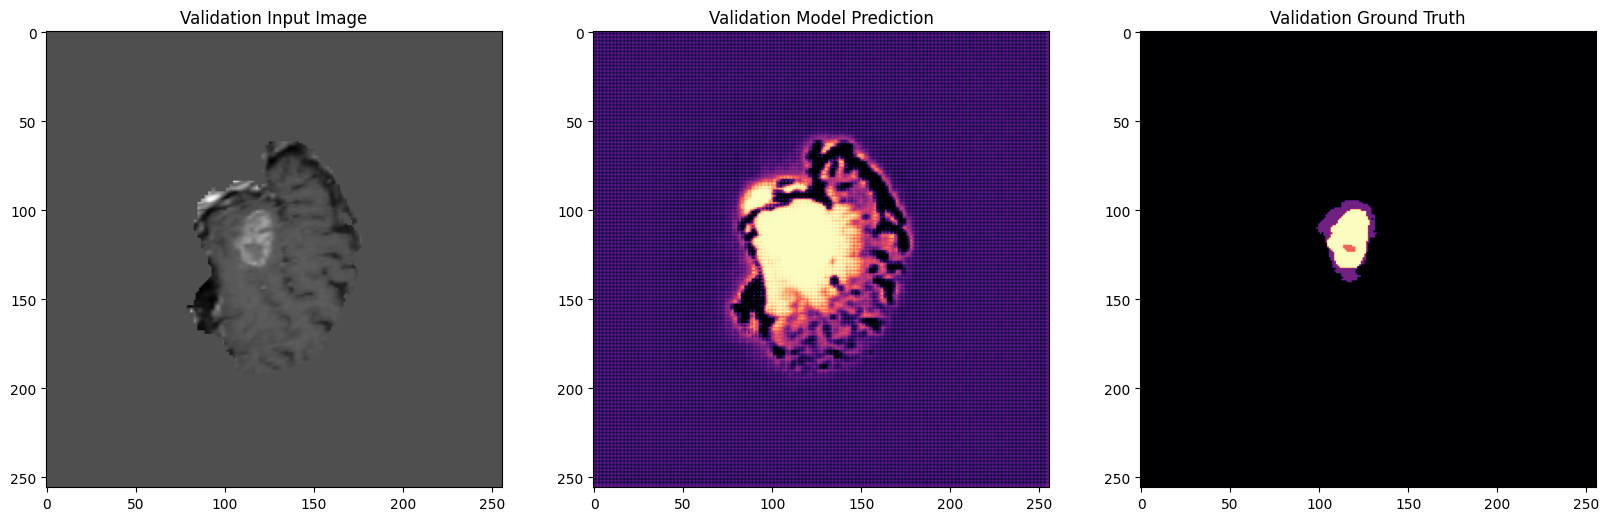

----------
epoch 3/50
epoch 3 average loss: 0.8002
current epoch: 3 train_set mean dice: 0.4530
time consuming of epoch 3 is: 43.1756
epoch 3 average validation loss: 0.7259
Best model saved with validation loss: 0.7259
Current Learning Rate: 0.0038531818838573157


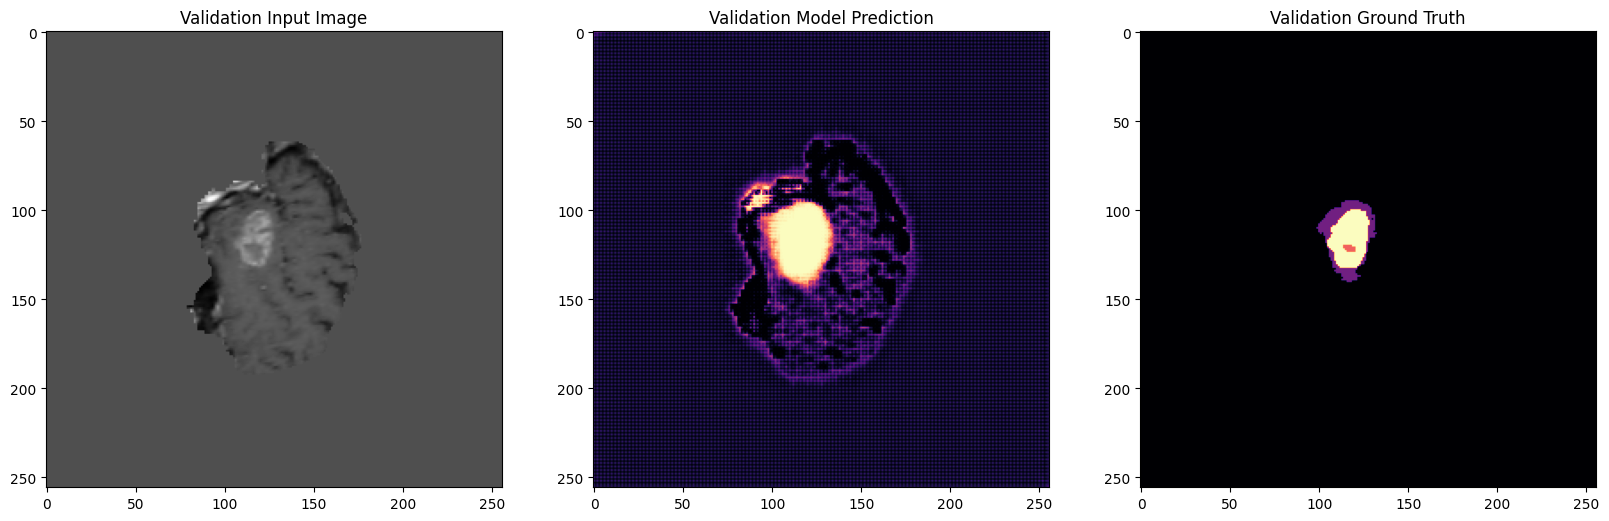

----------
epoch 4/50
epoch 4 average loss: 0.6461
current epoch: 4 train_set mean dice: 0.6363
time consuming of epoch 4 is: 44.2367
epoch 4 average validation loss: 0.5354
Best model saved with validation loss: 0.5354
Current Learning Rate: 0.0038531818838573157


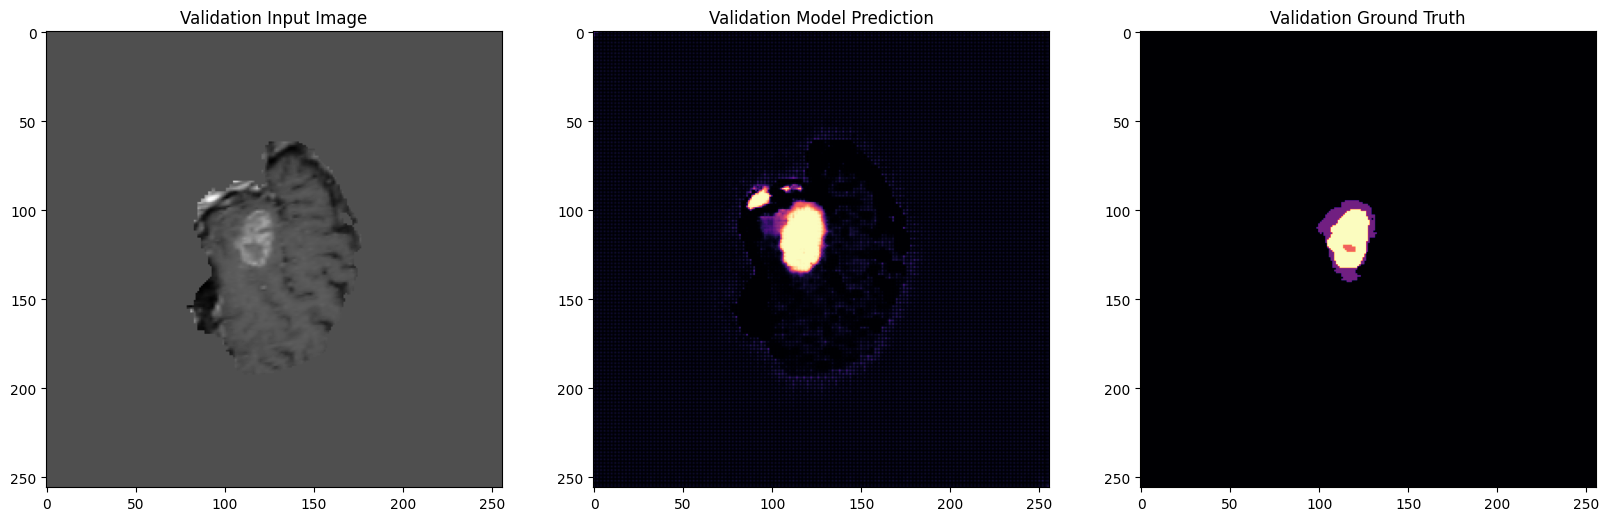

----------
epoch 5/50
epoch 5 average loss: 0.4654
current epoch: 5 train_set mean dice: 0.7288
time consuming of epoch 5 is: 46.1885
epoch 5 average validation loss: 0.3727
Best model saved with validation loss: 0.3727
Current Learning Rate: 0.0038531818838573157


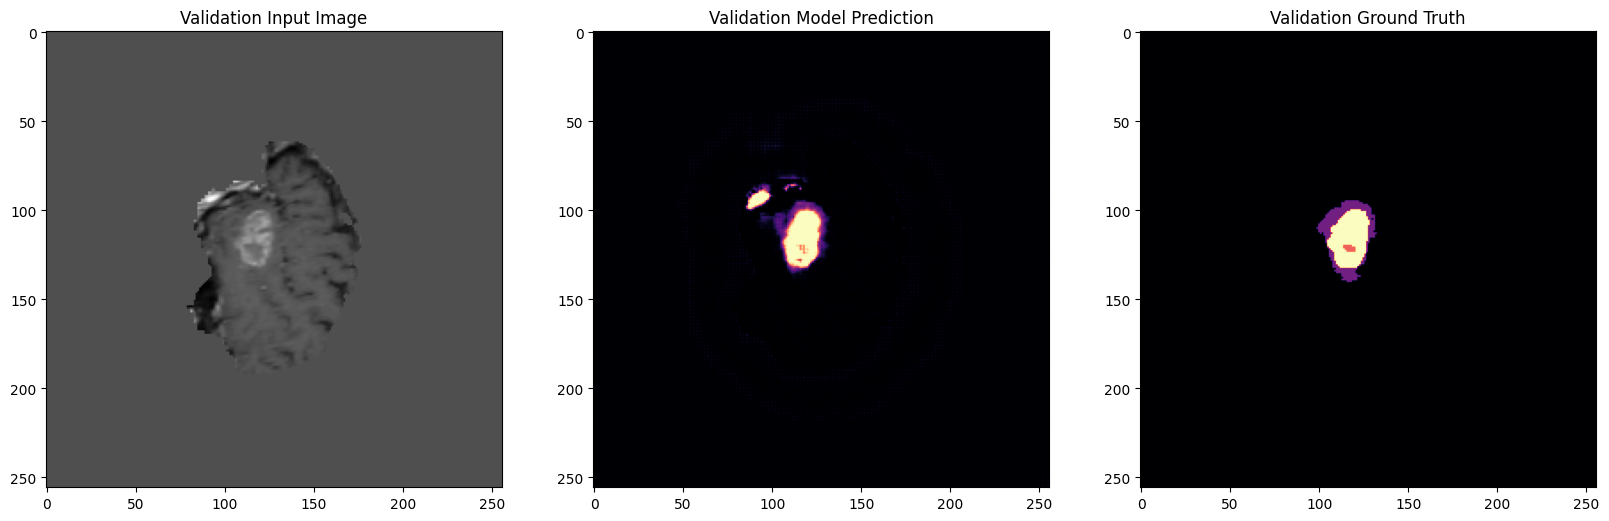

----------
epoch 6/50
epoch 6 average loss: 0.3570
current epoch: 6 train_set mean dice: 0.7673
time consuming of epoch 6 is: 46.4602
epoch 6 average validation loss: 0.3056
Best model saved with validation loss: 0.3056
Current Learning Rate: 0.0038531818838573157


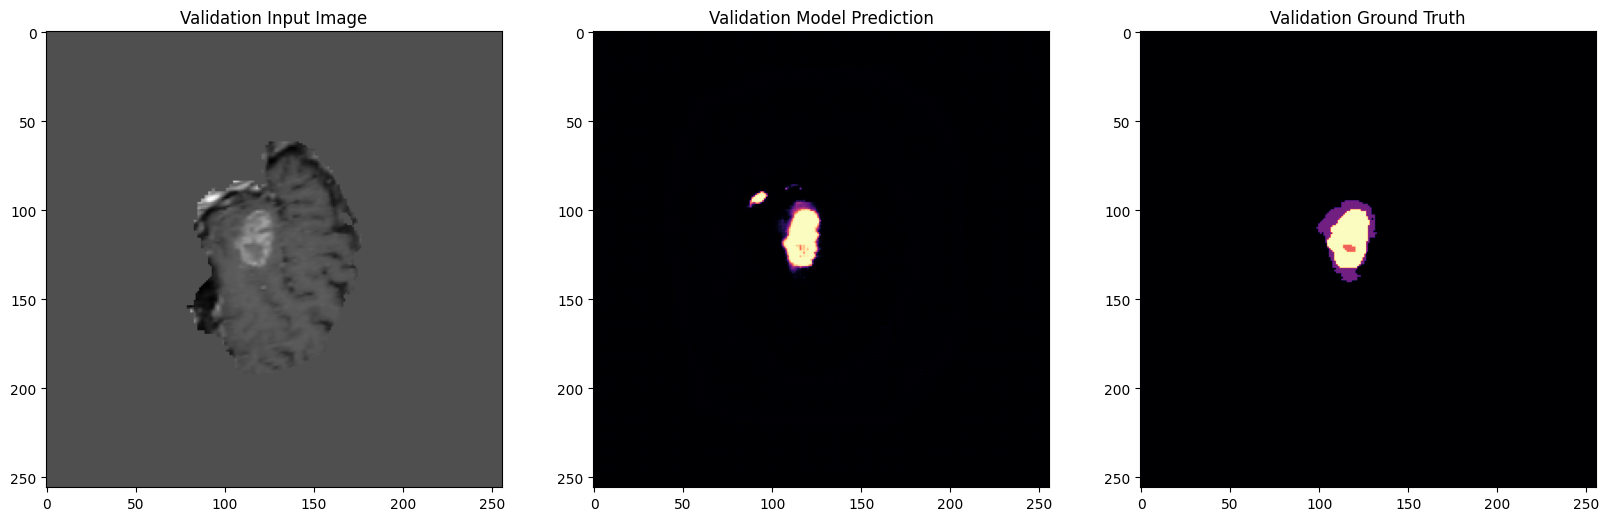

----------
epoch 7/50
epoch 7 average loss: 0.3169
current epoch: 7 train_set mean dice: 0.7826
time consuming of epoch 7 is: 44.5191
epoch 7 average validation loss: 0.2914
Best model saved with validation loss: 0.2914
Current Learning Rate: 0.0038531818838573157


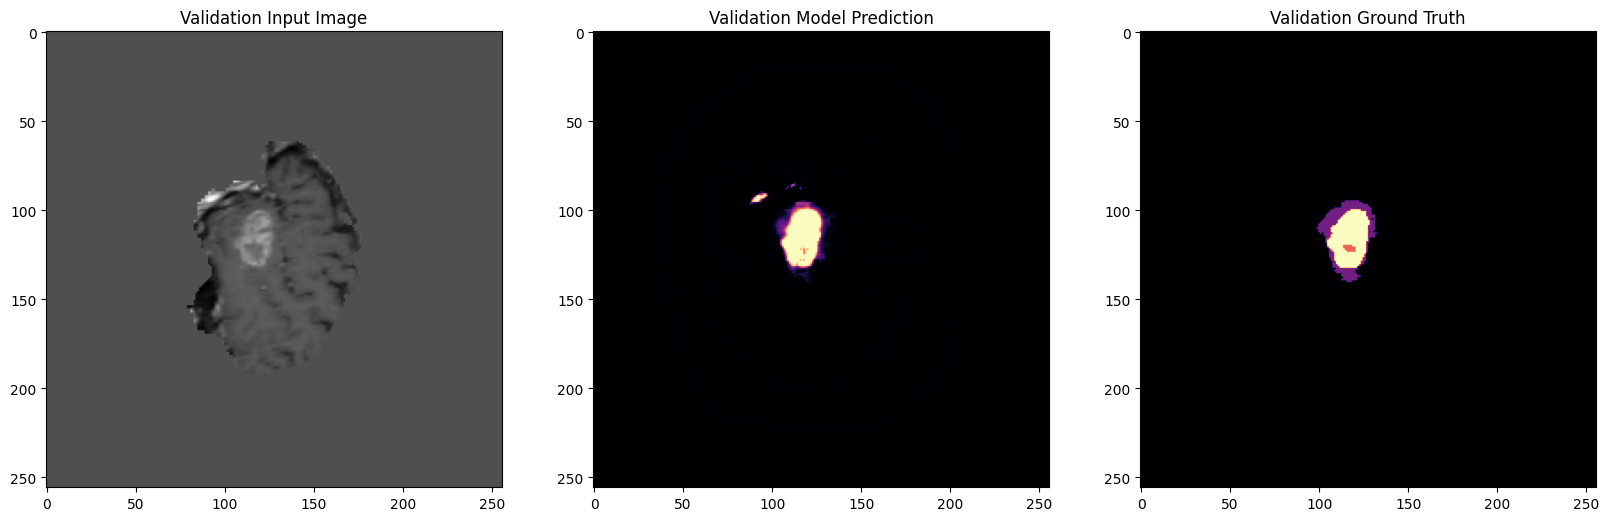

----------
epoch 8/50
epoch 8 average loss: 0.2925
current epoch: 8 train_set mean dice: 0.7965
time consuming of epoch 8 is: 44.7037
epoch 8 average validation loss: 0.2598
Best model saved with validation loss: 0.2598
Current Learning Rate: 0.0038531818838573157


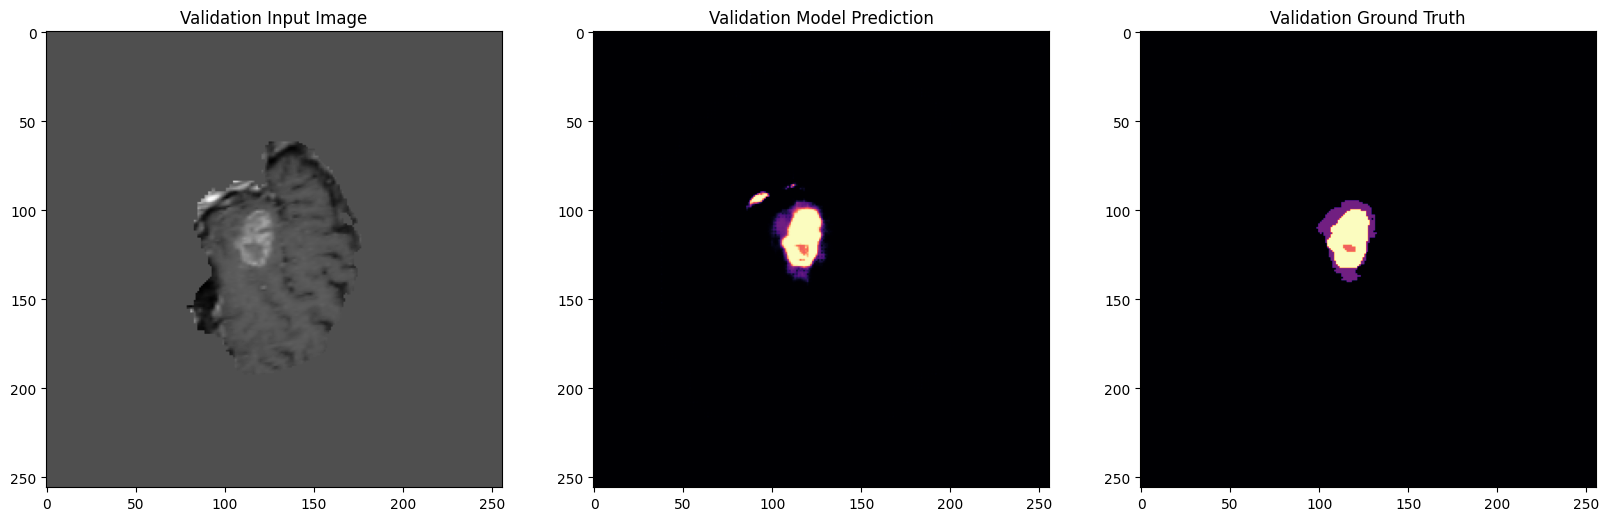

----------
epoch 9/50
epoch 9 average loss: 0.2728
current epoch: 9 train_set mean dice: 0.8123
time consuming of epoch 9 is: 43.6700
epoch 9 average validation loss: 0.2621
Current Learning Rate: 0.0038531818838573157


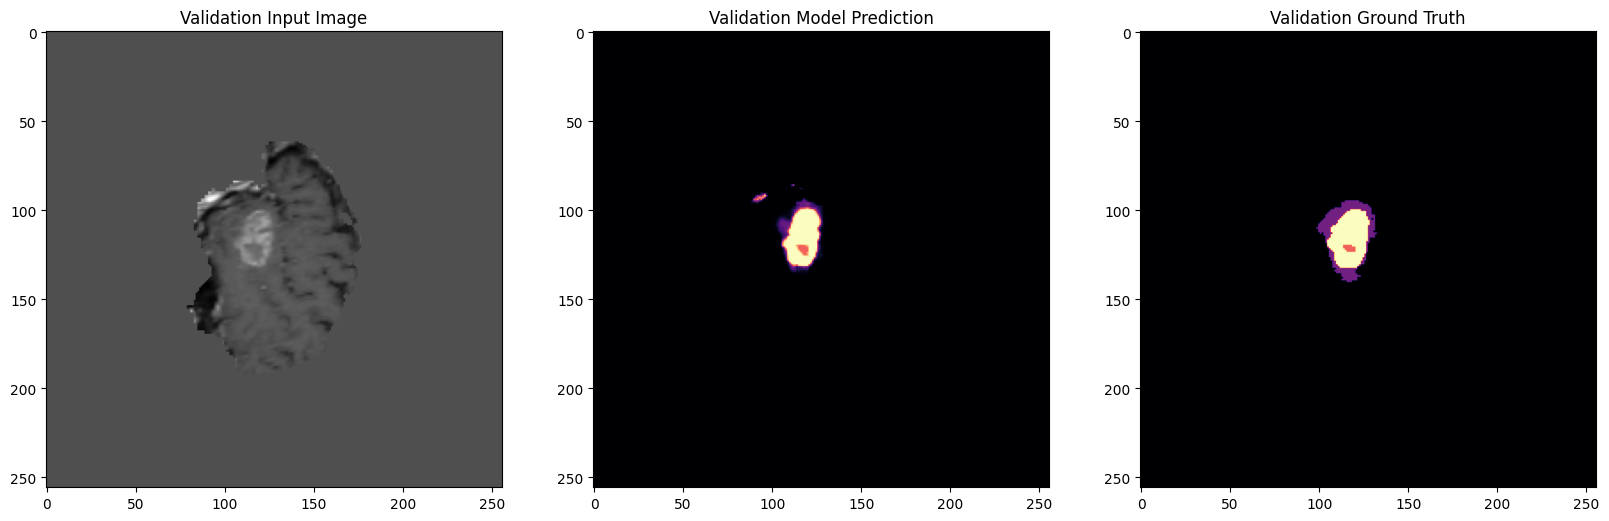

----------
epoch 10/50
epoch 10 average loss: 0.2609
current epoch: 10 train_set mean dice: 0.8193
time consuming of epoch 10 is: 43.8997
epoch 10 average validation loss: 0.2457
Best model saved with validation loss: 0.2457
Current Learning Rate: 0.0038531818838573157


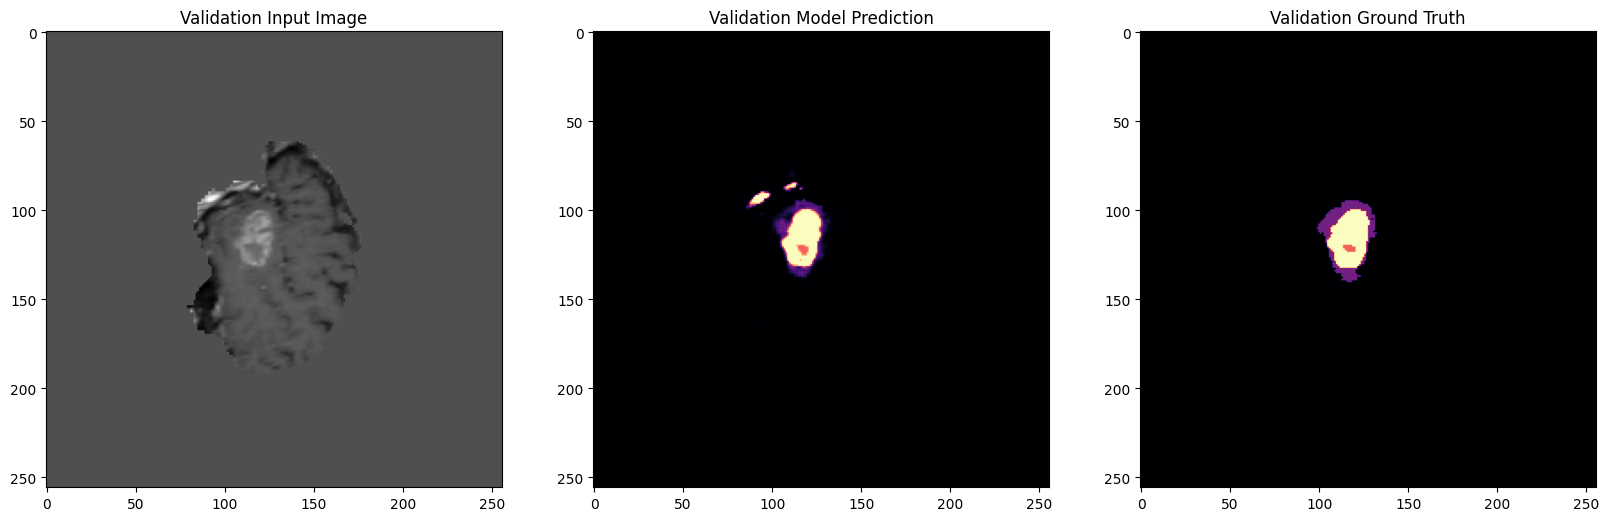

----------
epoch 11/50
epoch 11 average loss: 0.2589
current epoch: 11 train_set mean dice: 0.8215
time consuming of epoch 11 is: 43.7215
epoch 11 average validation loss: 0.2501
Current Learning Rate: 0.0038531818838573157


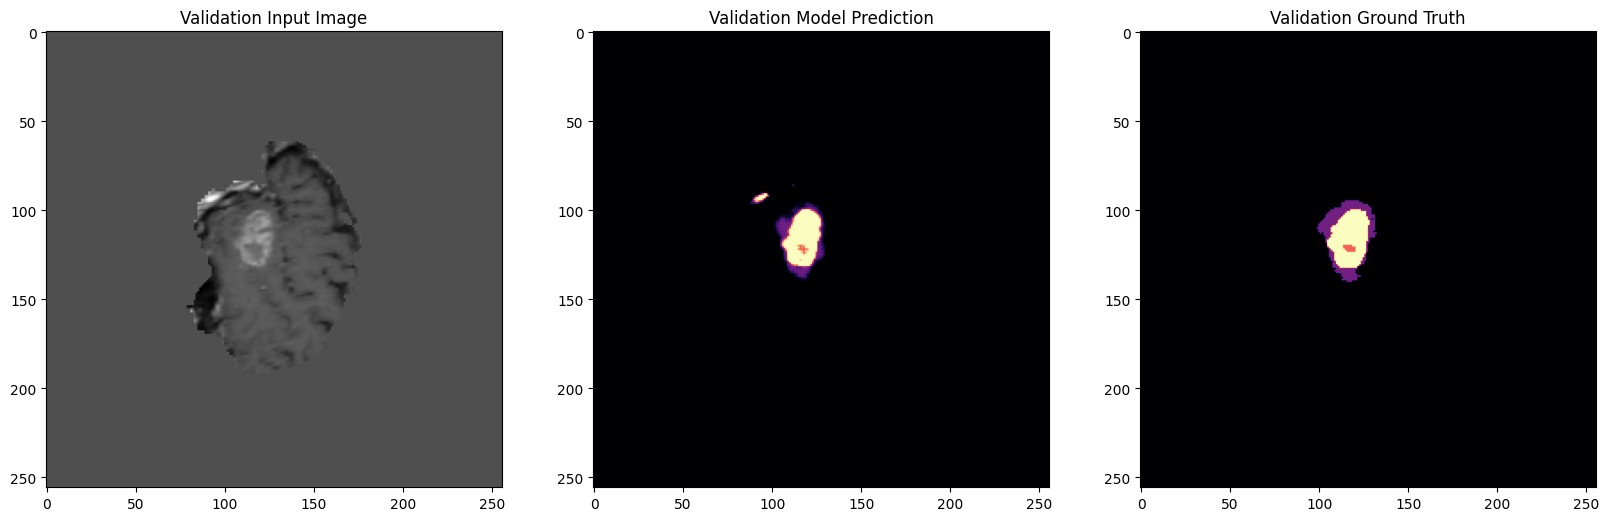

----------
epoch 12/50
epoch 12 average loss: 0.2461
current epoch: 12 train_set mean dice: 0.8282
time consuming of epoch 12 is: 42.7792
epoch 12 average validation loss: 0.2309
Best model saved with validation loss: 0.2309
Current Learning Rate: 0.0038531818838573157


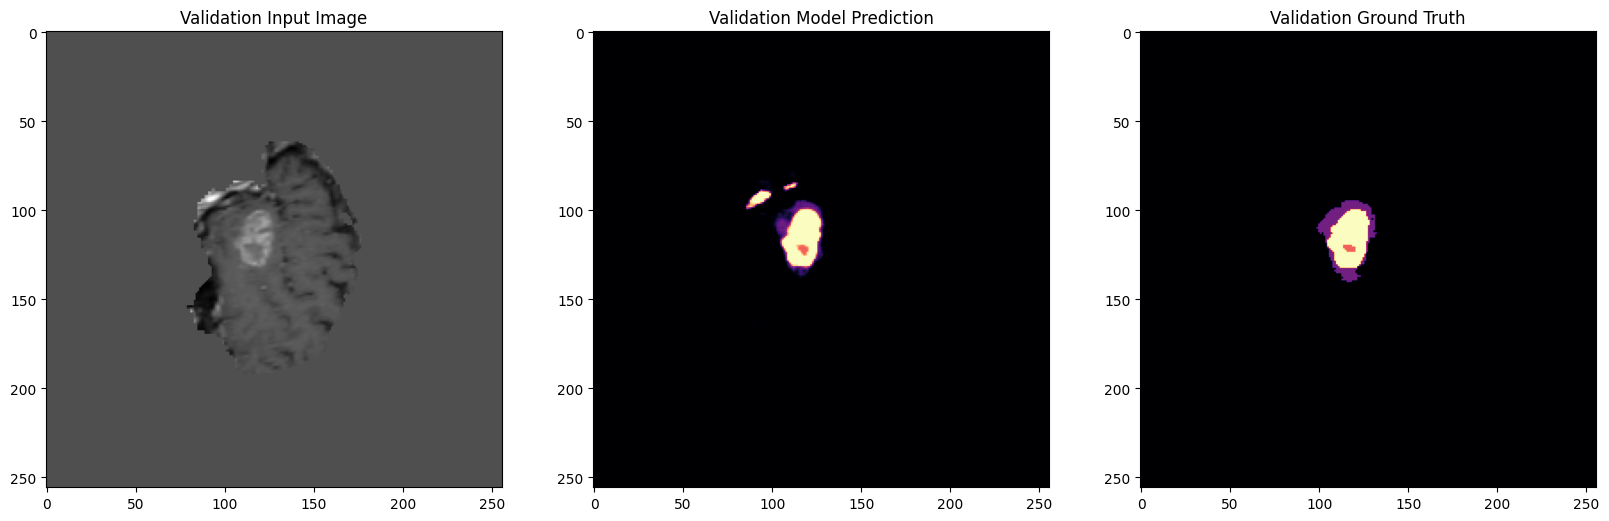

----------
epoch 13/50
epoch 13 average loss: 0.2430
current epoch: 13 train_set mean dice: 0.8303
time consuming of epoch 13 is: 41.2803
epoch 13 average validation loss: 0.2321
Current Learning Rate: 0.0038531818838573157


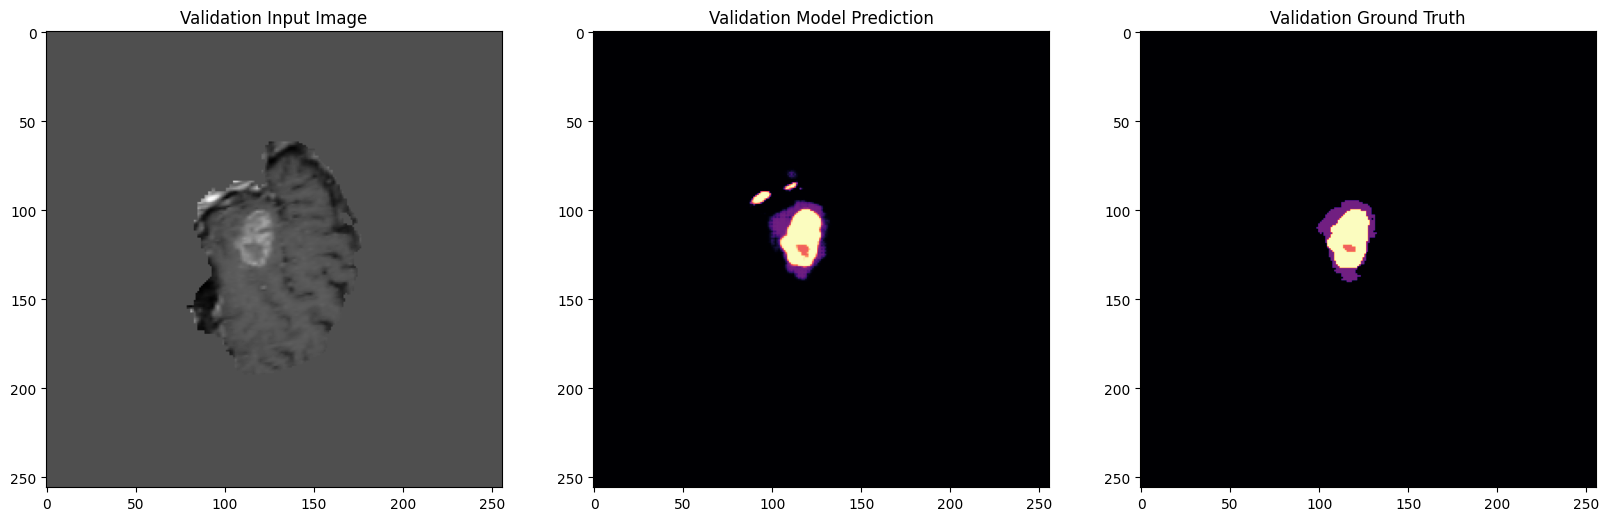

----------
epoch 14/50
epoch 14 average loss: 0.2379
current epoch: 14 train_set mean dice: 0.8348
time consuming of epoch 14 is: 41.3097
epoch 14 average validation loss: 0.2277
Best model saved with validation loss: 0.2277
Current Learning Rate: 0.0038531818838573157


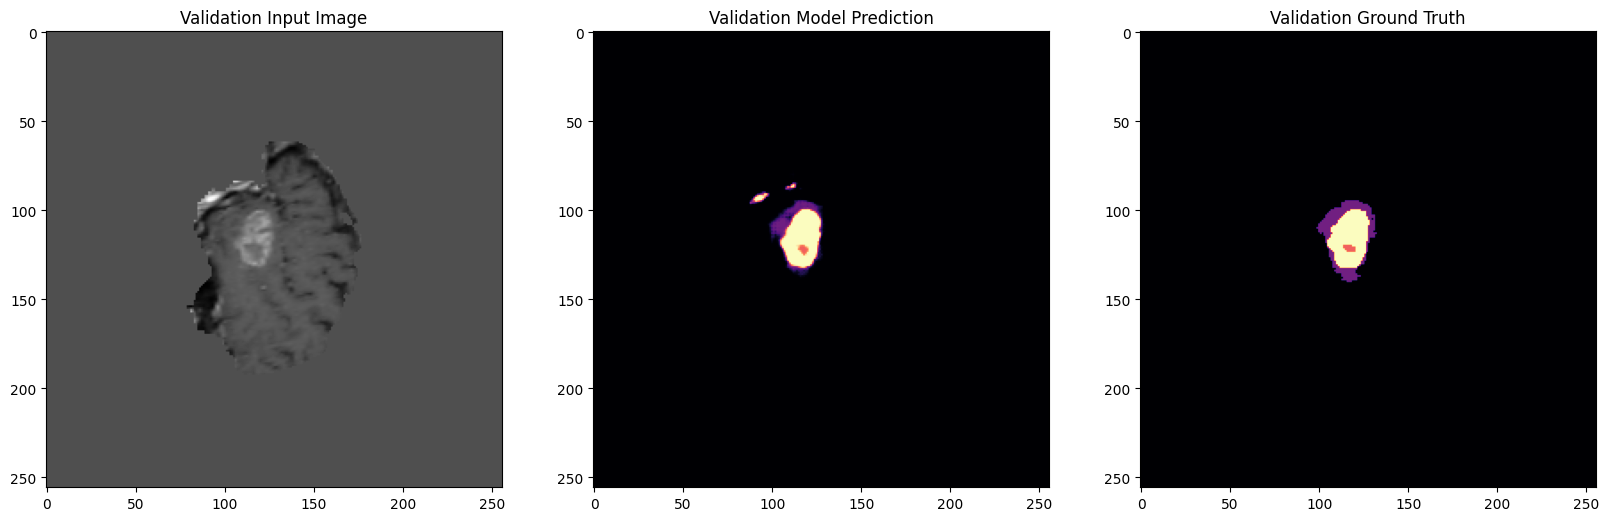

----------
epoch 15/50
epoch 15 average loss: 0.2358
current epoch: 15 train_set mean dice: 0.8359
time consuming of epoch 15 is: 41.2123
epoch 15 average validation loss: 0.2310
Current Learning Rate: 0.0038531818838573157


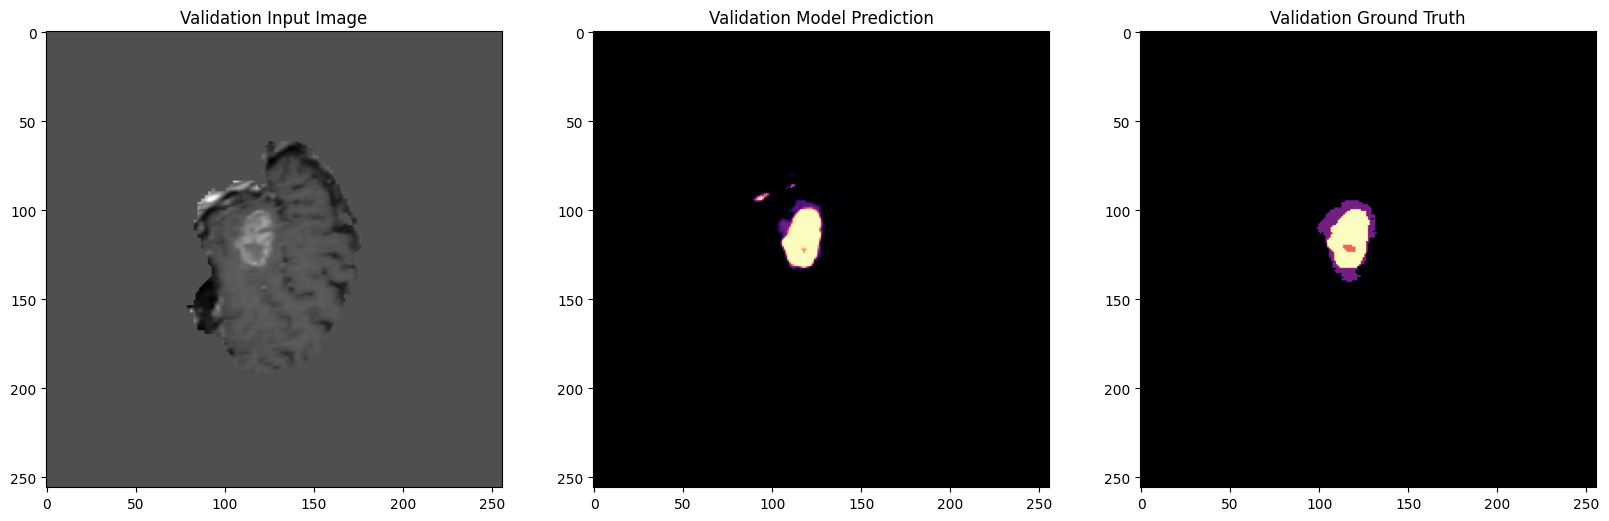

----------
epoch 16/50
epoch 16 average loss: 0.2318
current epoch: 16 train_set mean dice: 0.8388
time consuming of epoch 16 is: 41.1217
epoch 16 average validation loss: 0.2285
Current Learning Rate: 0.0038531818838573157


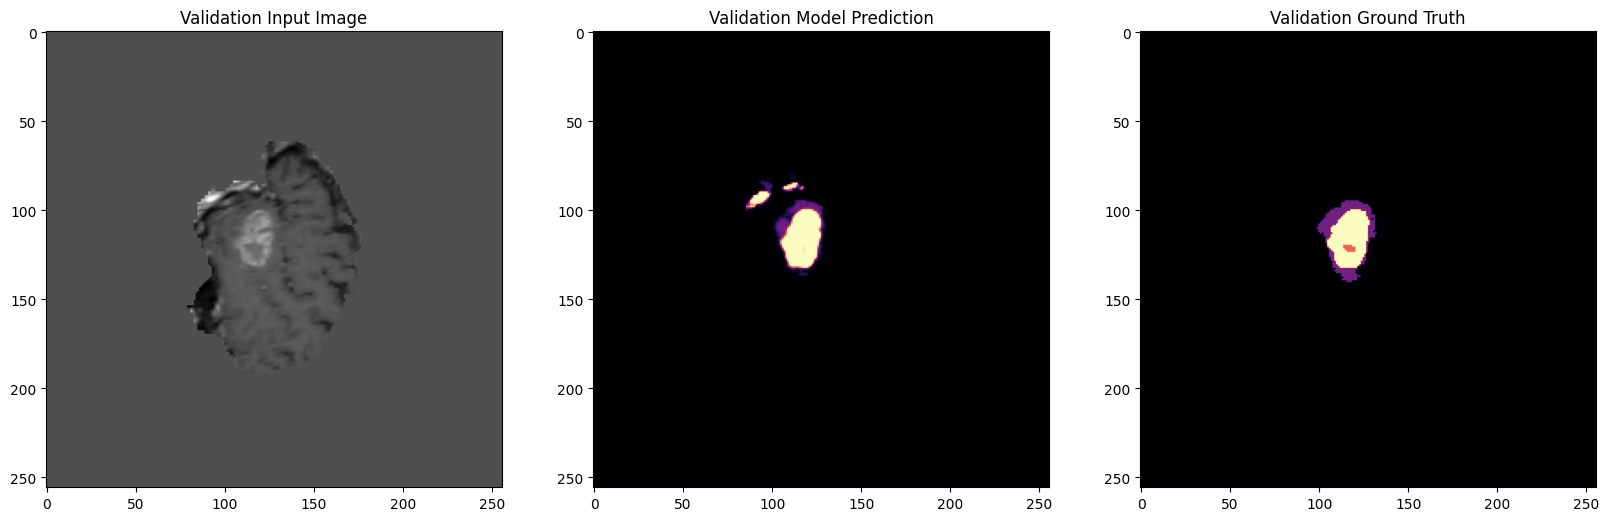

----------
epoch 17/50
epoch 17 average loss: 0.2278
current epoch: 17 train_set mean dice: 0.8430
time consuming of epoch 17 is: 41.1711
epoch 17 average validation loss: 0.2221
Best model saved with validation loss: 0.2221
Current Learning Rate: 0.0038531818838573157


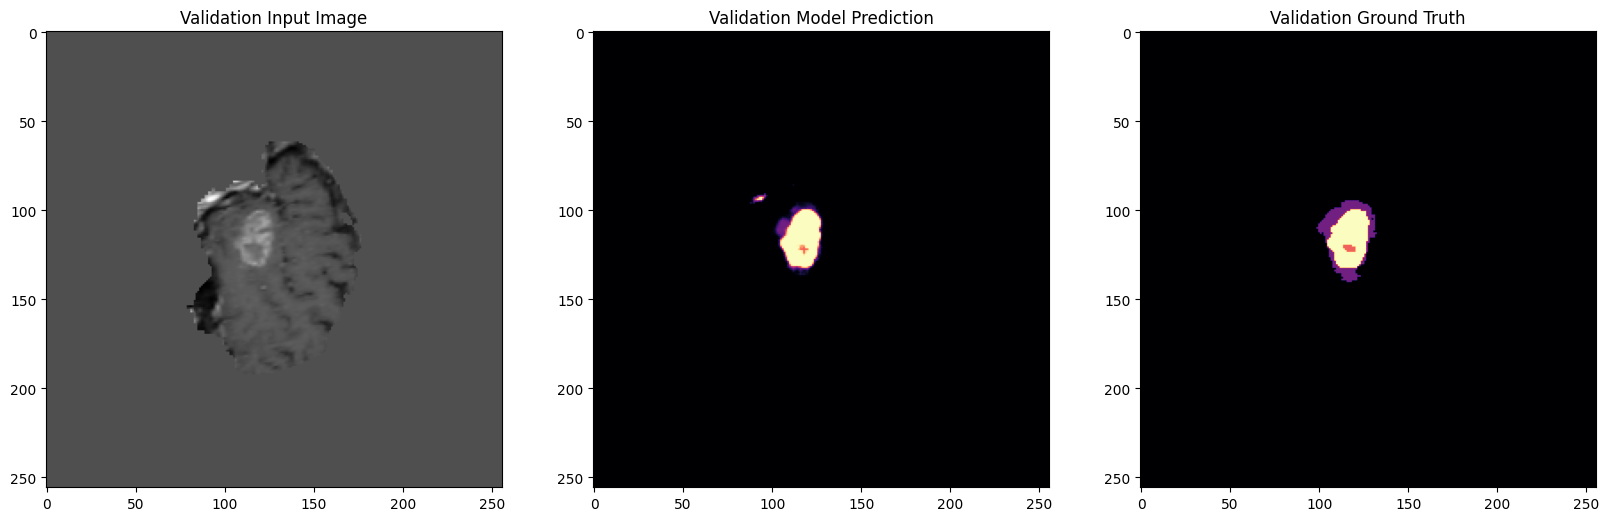

----------
epoch 18/50
epoch 18 average loss: 0.2213
current epoch: 18 train_set mean dice: 0.8475
time consuming of epoch 18 is: 41.7736
epoch 18 average validation loss: 0.2179
Best model saved with validation loss: 0.2179
Current Learning Rate: 0.0038531818838573157


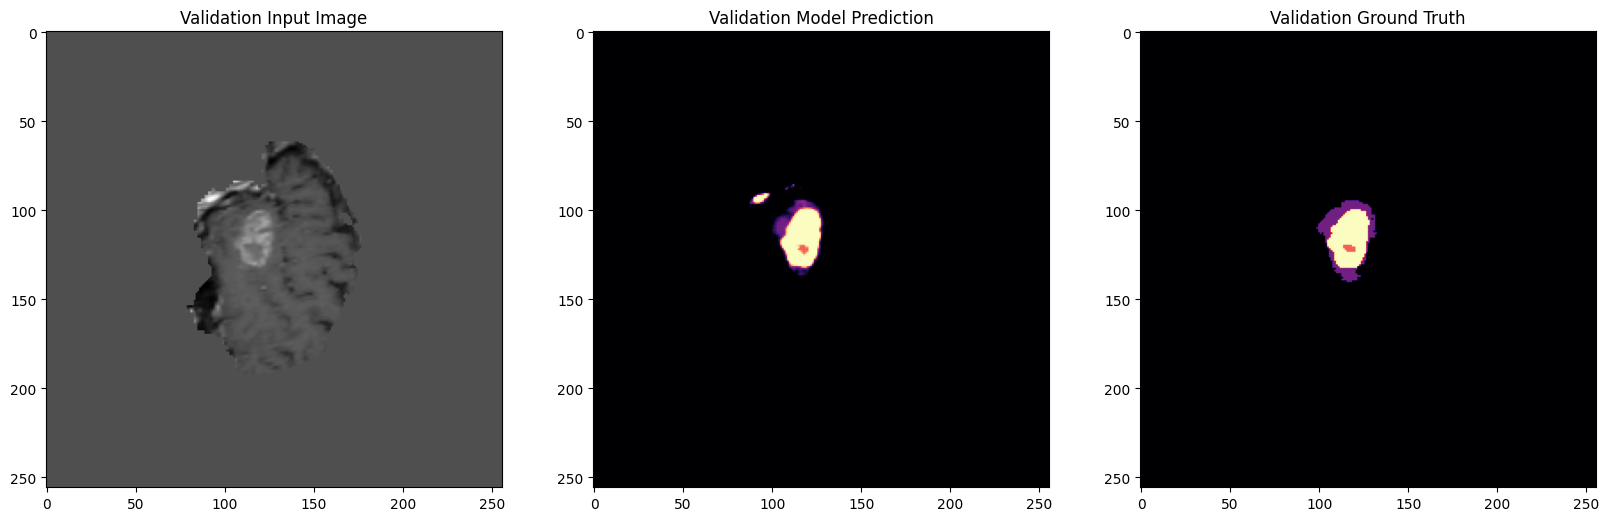

----------
epoch 19/50
epoch 19 average loss: 0.2187
current epoch: 19 train_set mean dice: 0.8520
time consuming of epoch 19 is: 43.1380
epoch 19 average validation loss: 0.2191
Current Learning Rate: 0.0038531818838573157


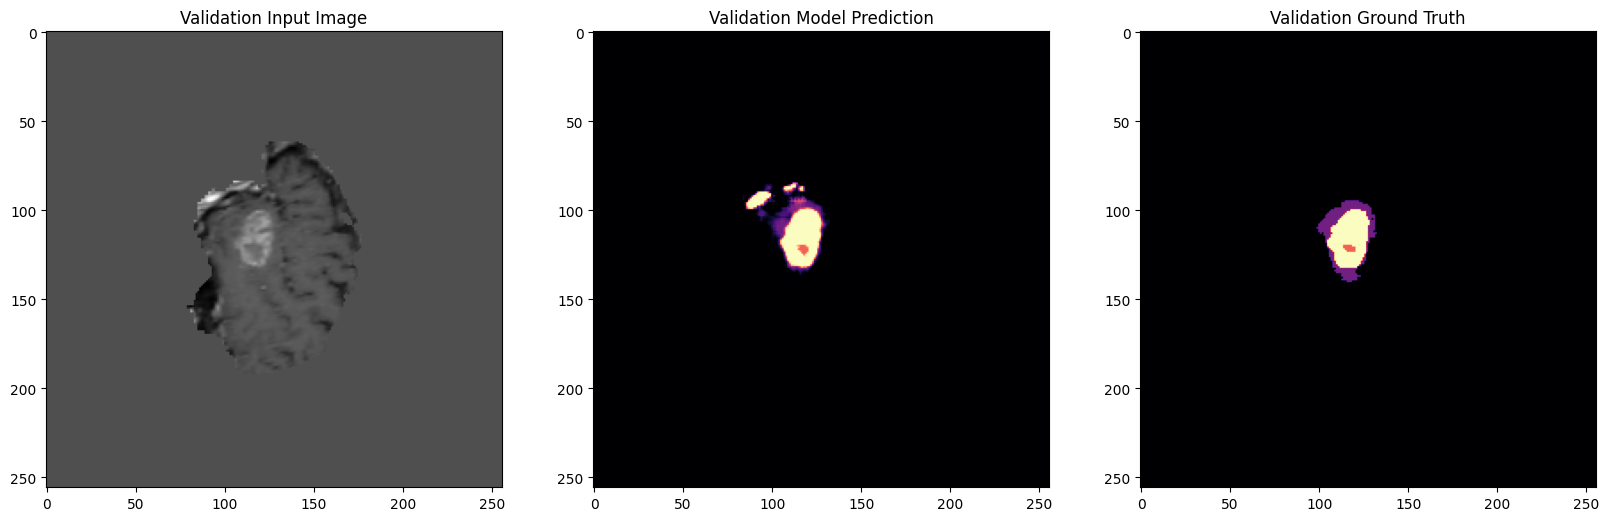

----------
epoch 20/50
epoch 20 average loss: 0.2179
current epoch: 20 train_set mean dice: 0.8500
time consuming of epoch 20 is: 43.8278
epoch 20 average validation loss: 0.2241
Current Learning Rate: 0.0038531818838573157


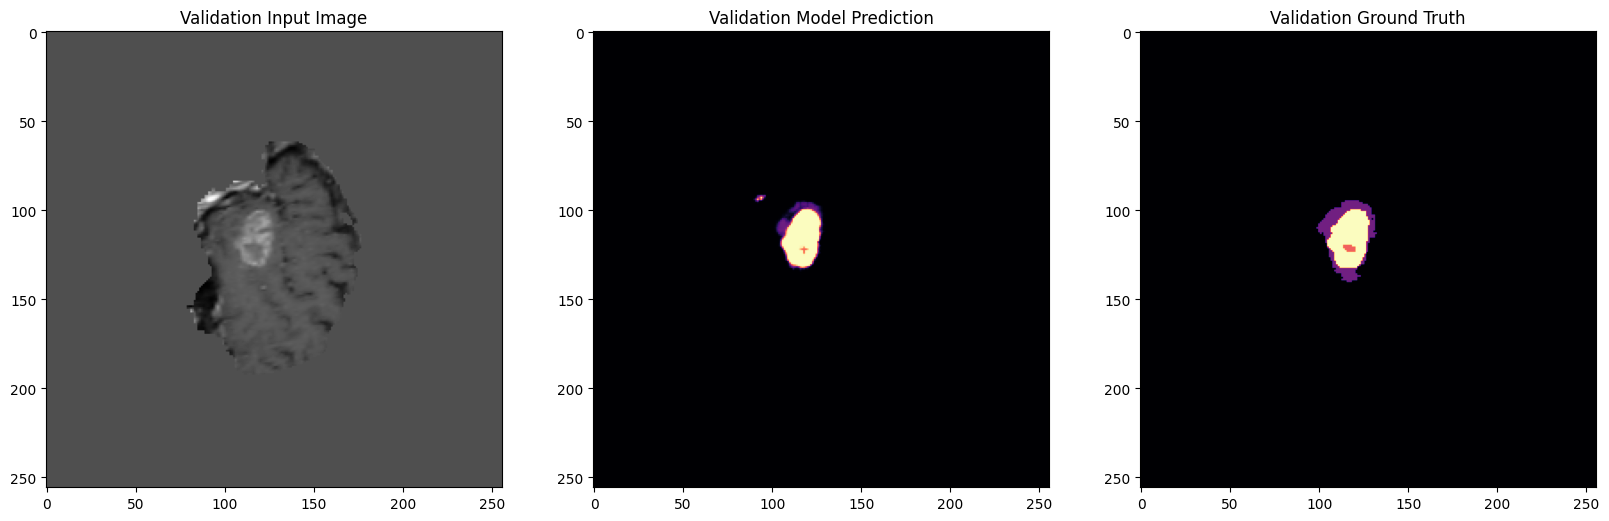

----------
epoch 21/50
epoch 21 average loss: 0.2163
current epoch: 21 train_set mean dice: 0.8541
time consuming of epoch 21 is: 44.4030
epoch 21 average validation loss: 0.2210
Current Learning Rate: 0.0038531818838573157


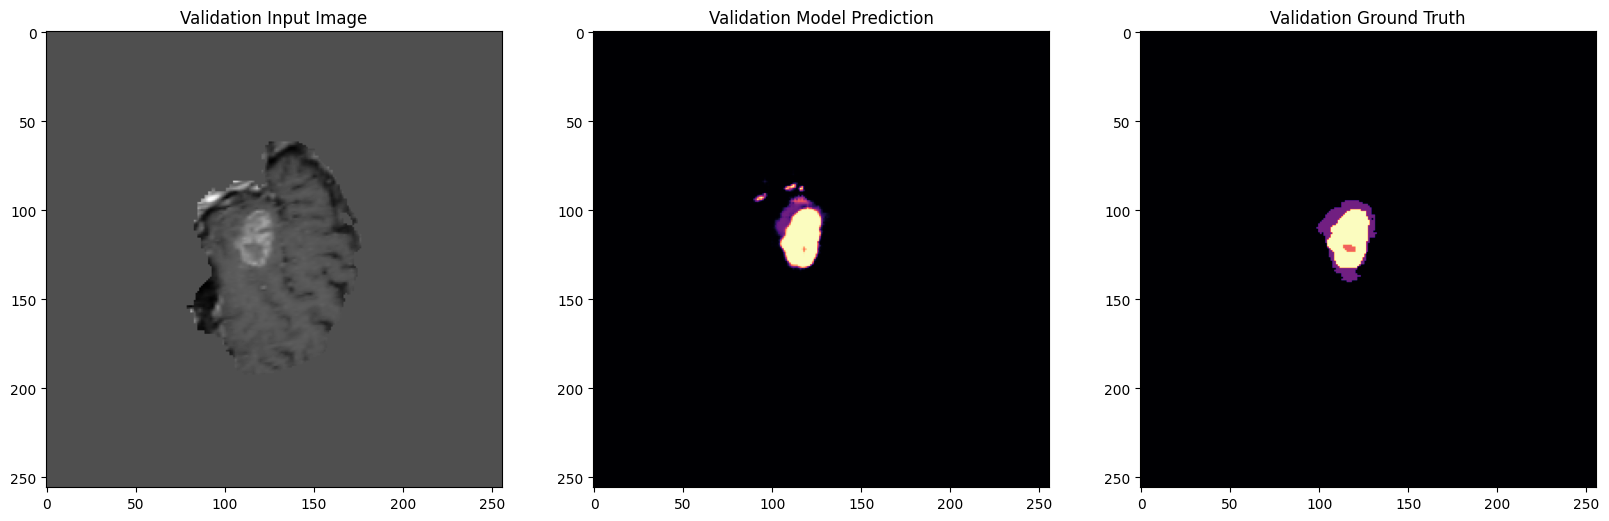

----------
epoch 22/50
epoch 22 average loss: 0.2166
current epoch: 22 train_set mean dice: 0.8552
time consuming of epoch 22 is: 43.9073
epoch 22 average validation loss: 0.2240
Current Learning Rate: 0.0038531818838573157


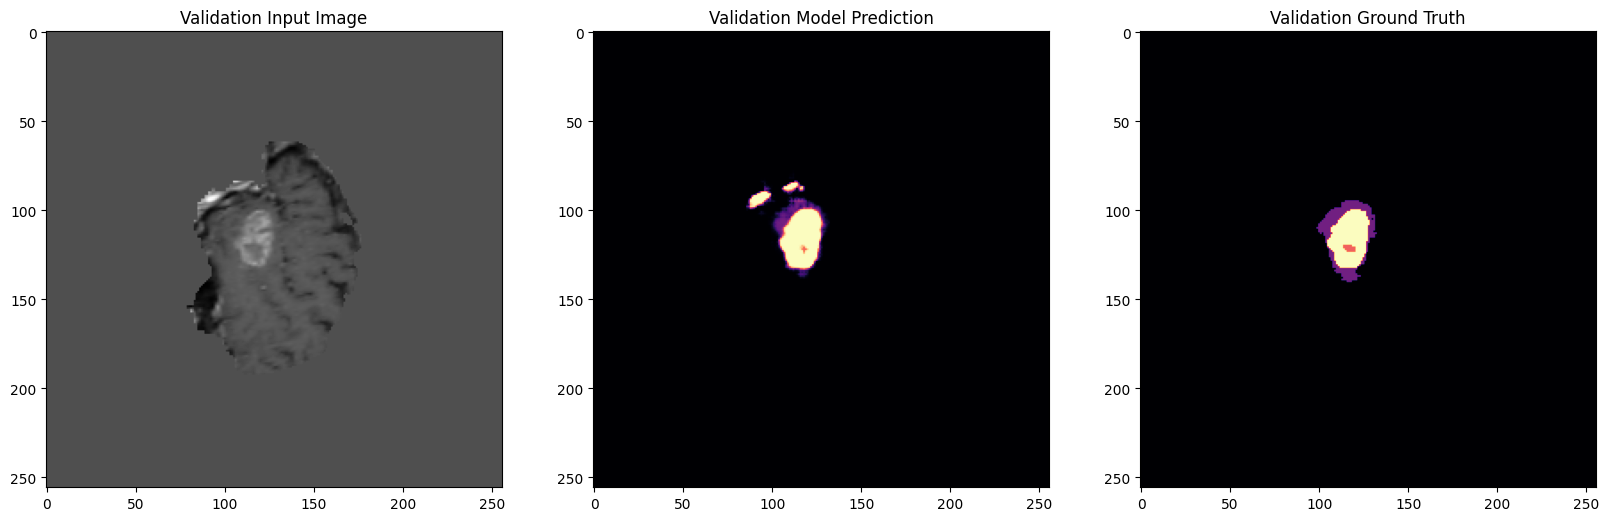

----------
epoch 23/50
epoch 23 average loss: 0.2156
current epoch: 23 train_set mean dice: 0.8520
time consuming of epoch 23 is: 42.9083
epoch 23 average validation loss: 0.2164
Best model saved with validation loss: 0.2164
Current Learning Rate: 0.0038531818838573157


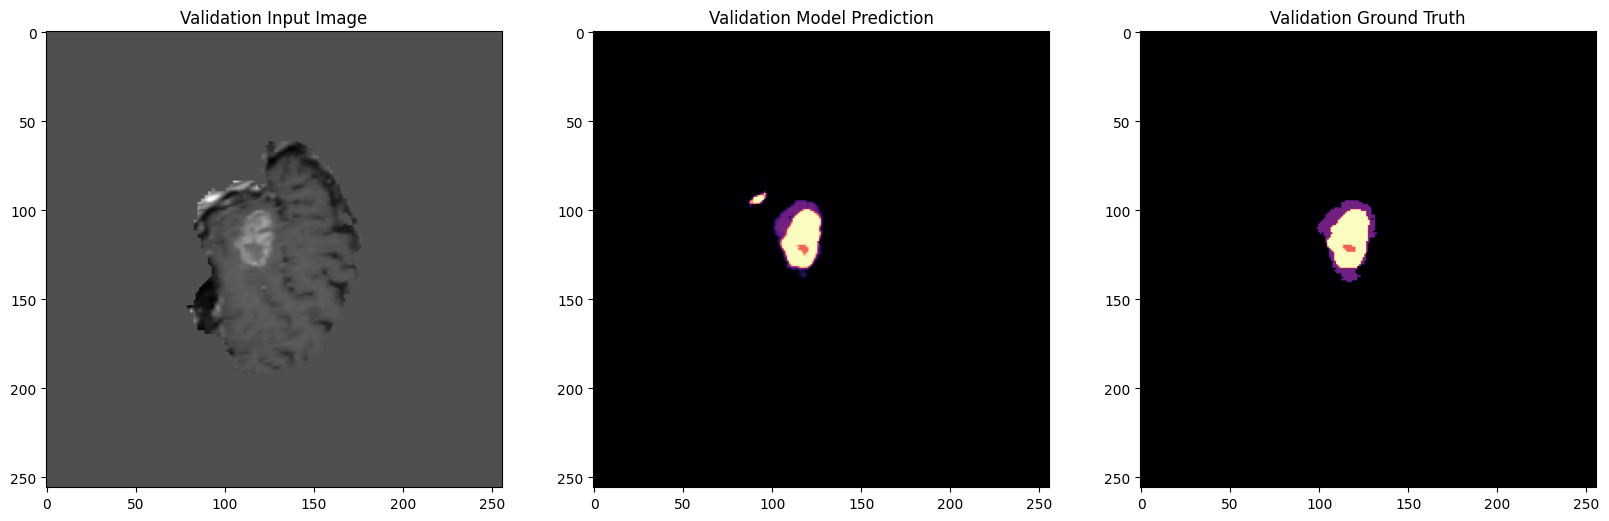

----------
epoch 24/50
epoch 24 average loss: 0.2047
current epoch: 24 train_set mean dice: 0.8623
time consuming of epoch 24 is: 43.9433
epoch 24 average validation loss: 0.2268
Current Learning Rate: 0.0038531818838573157


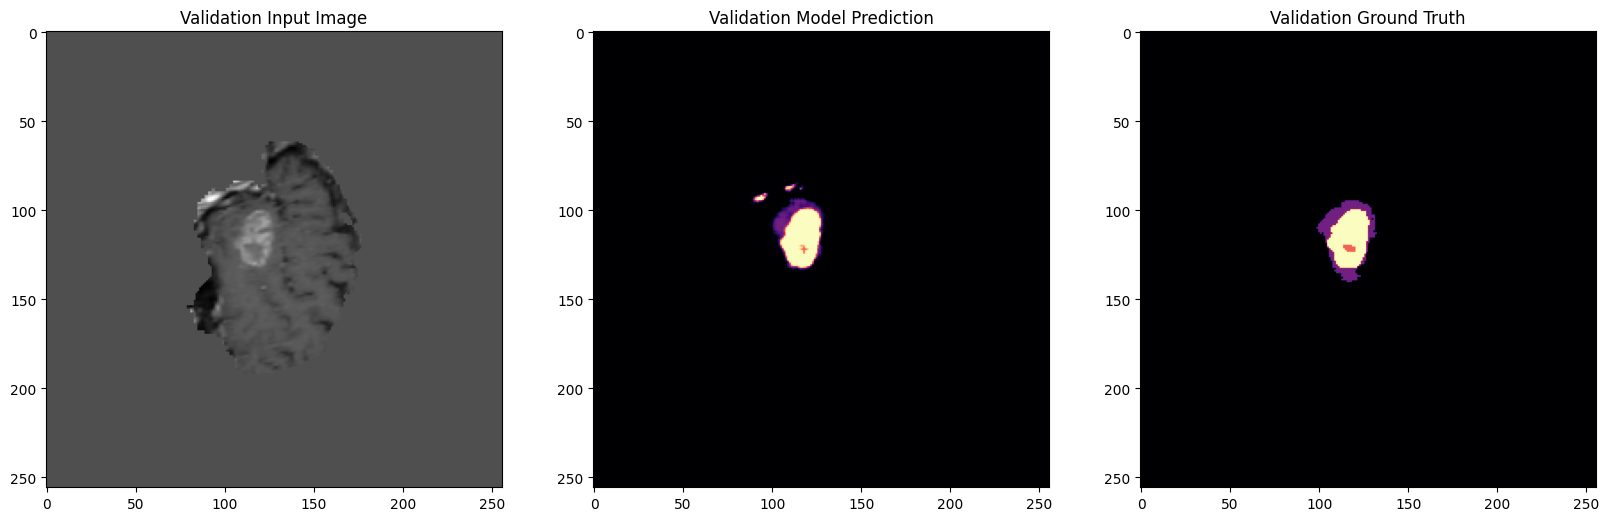

----------
epoch 25/50
epoch 25 average loss: 0.2163
current epoch: 25 train_set mean dice: 0.8528
time consuming of epoch 25 is: 42.9303
epoch 25 average validation loss: 0.2144
Best model saved with validation loss: 0.2144
Current Learning Rate: 0.0038531818838573157


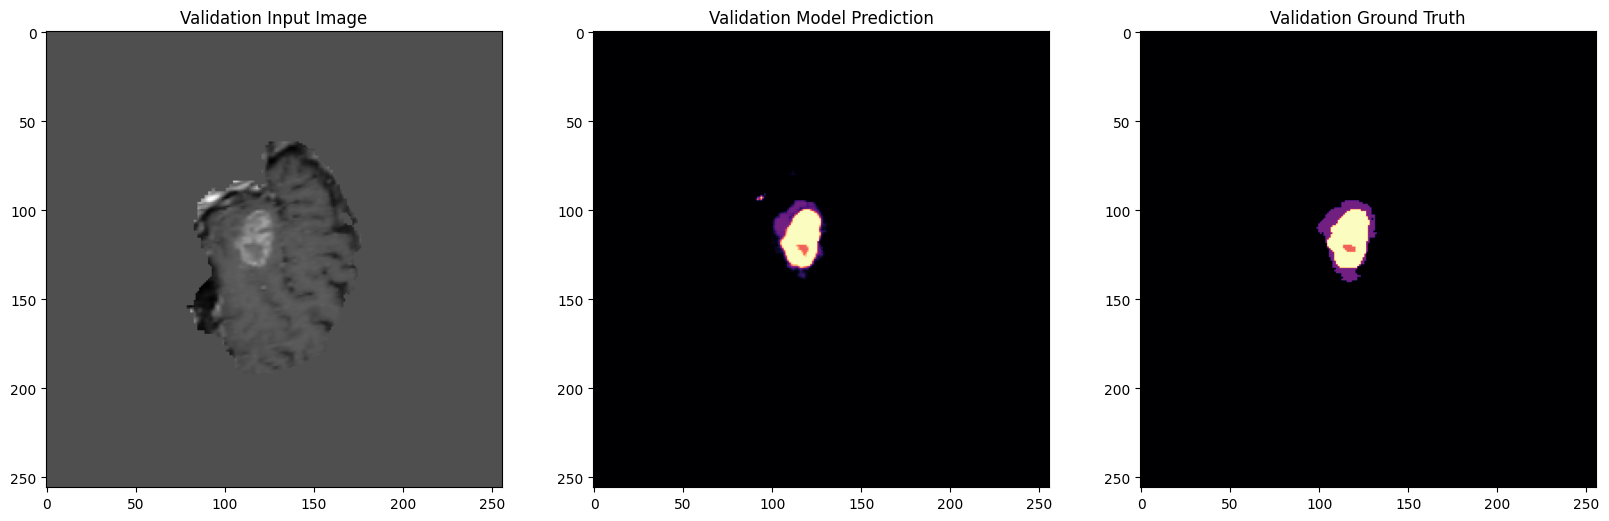

----------
epoch 26/50
epoch 26 average loss: 0.2123
current epoch: 26 train_set mean dice: 0.8551
time consuming of epoch 26 is: 41.5519
epoch 26 average validation loss: 0.2157
Current Learning Rate: 0.0038531818838573157


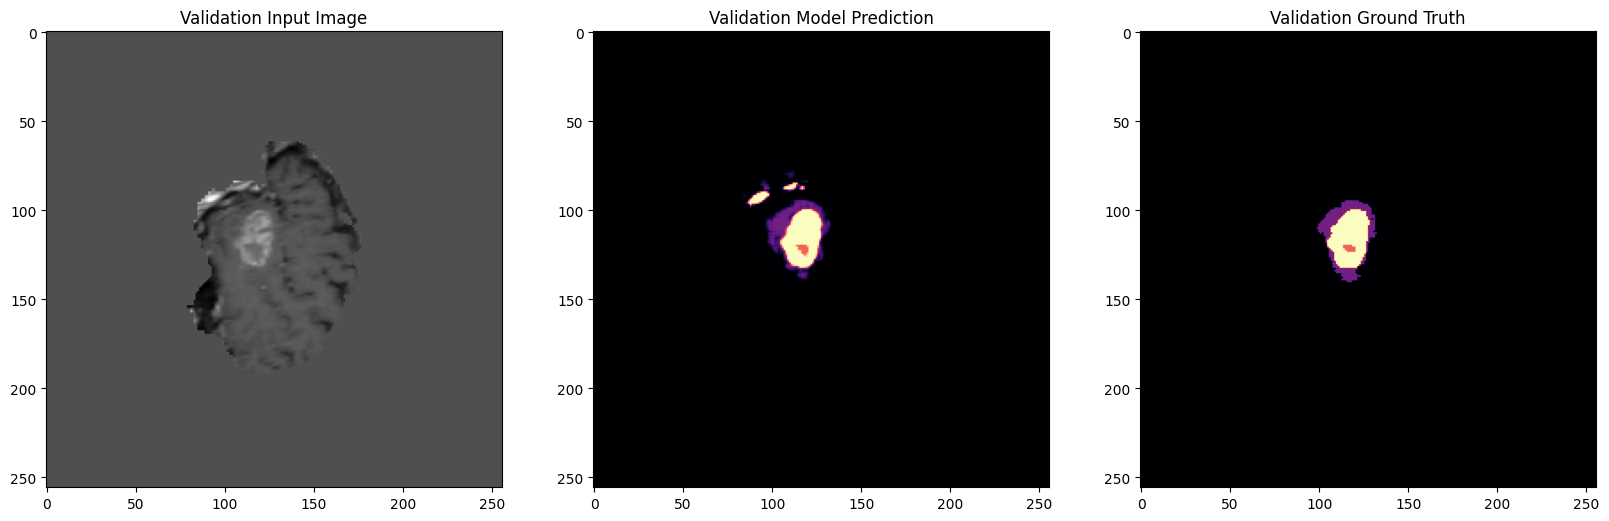

----------
epoch 27/50
epoch 27 average loss: 0.2065
current epoch: 27 train_set mean dice: 0.8606
time consuming of epoch 27 is: 41.6622
epoch 27 average validation loss: 0.2146
Current Learning Rate: 0.0038531818838573157


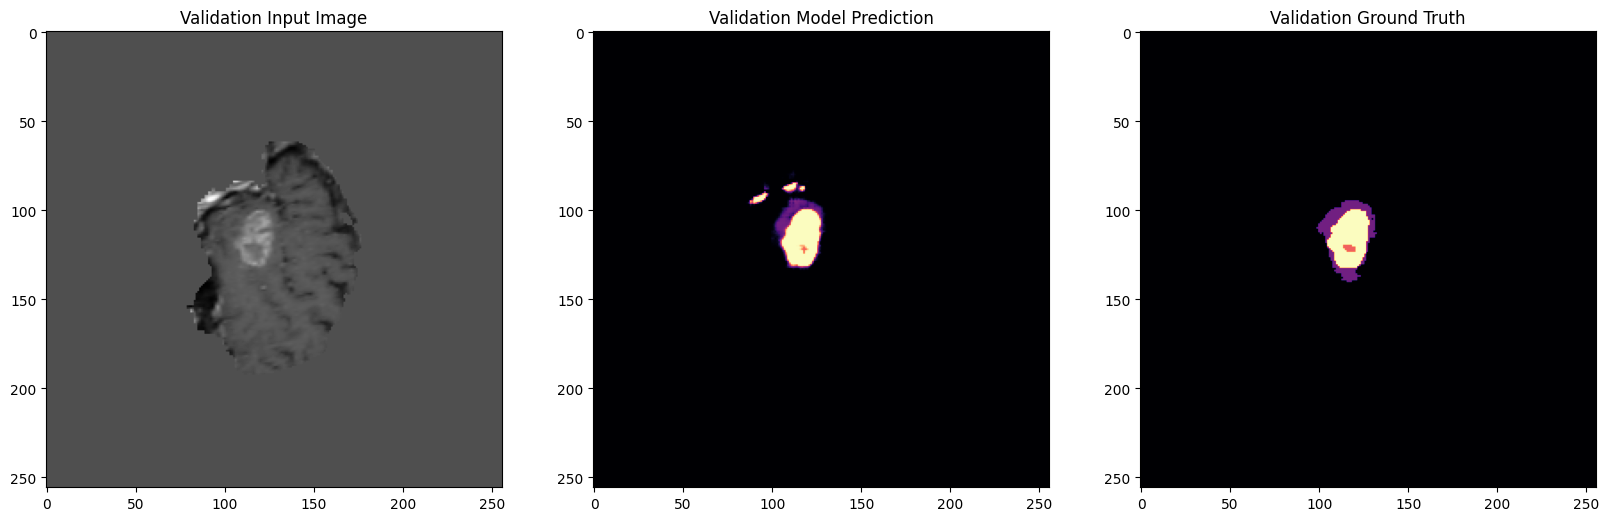

----------
epoch 28/50
epoch 28 average loss: 0.2037
current epoch: 28 train_set mean dice: 0.8645
time consuming of epoch 28 is: 40.8465
epoch 28 average validation loss: 0.2242
Current Learning Rate: 0.0038531818838573157


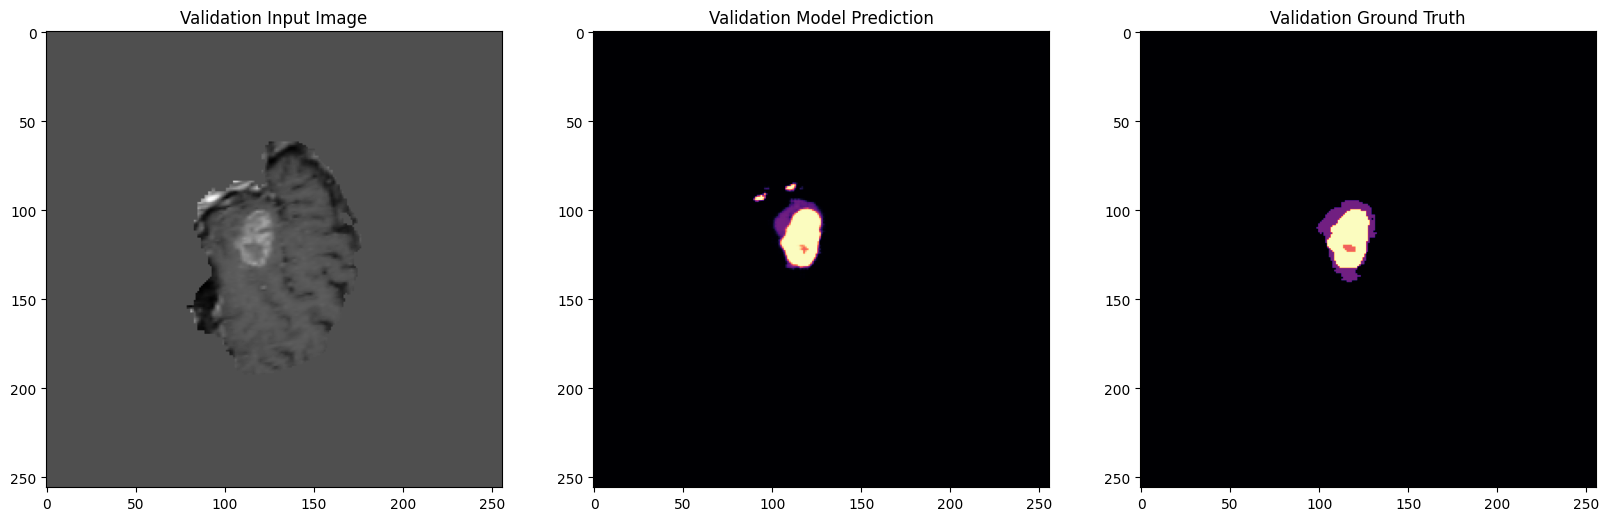

----------
epoch 29/50
epoch 29 average loss: 0.2039
current epoch: 29 train_set mean dice: 0.8625
time consuming of epoch 29 is: 41.1909
epoch 29 average validation loss: 0.2118
Best model saved with validation loss: 0.2118
Current Learning Rate: 0.0038531818838573157


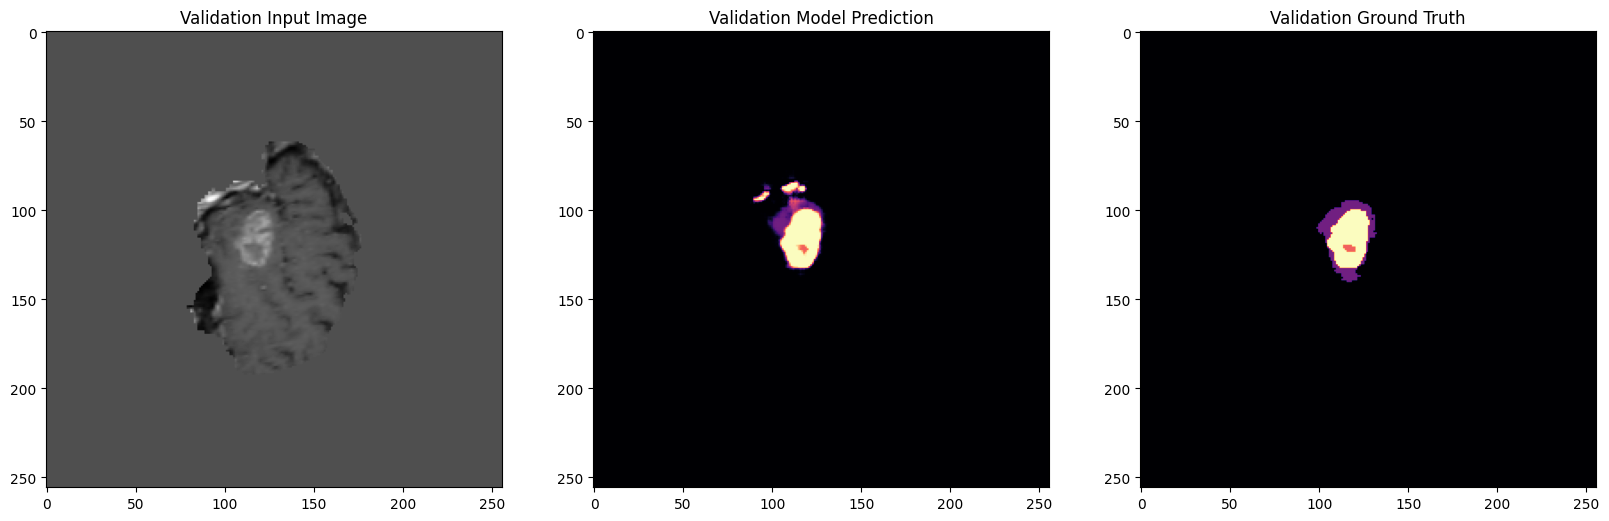

----------
epoch 30/50
epoch 30 average loss: 0.2032
current epoch: 30 train_set mean dice: 0.8654
time consuming of epoch 30 is: 41.6142
epoch 30 average validation loss: 0.2148
Current Learning Rate: 0.0038531818838573157


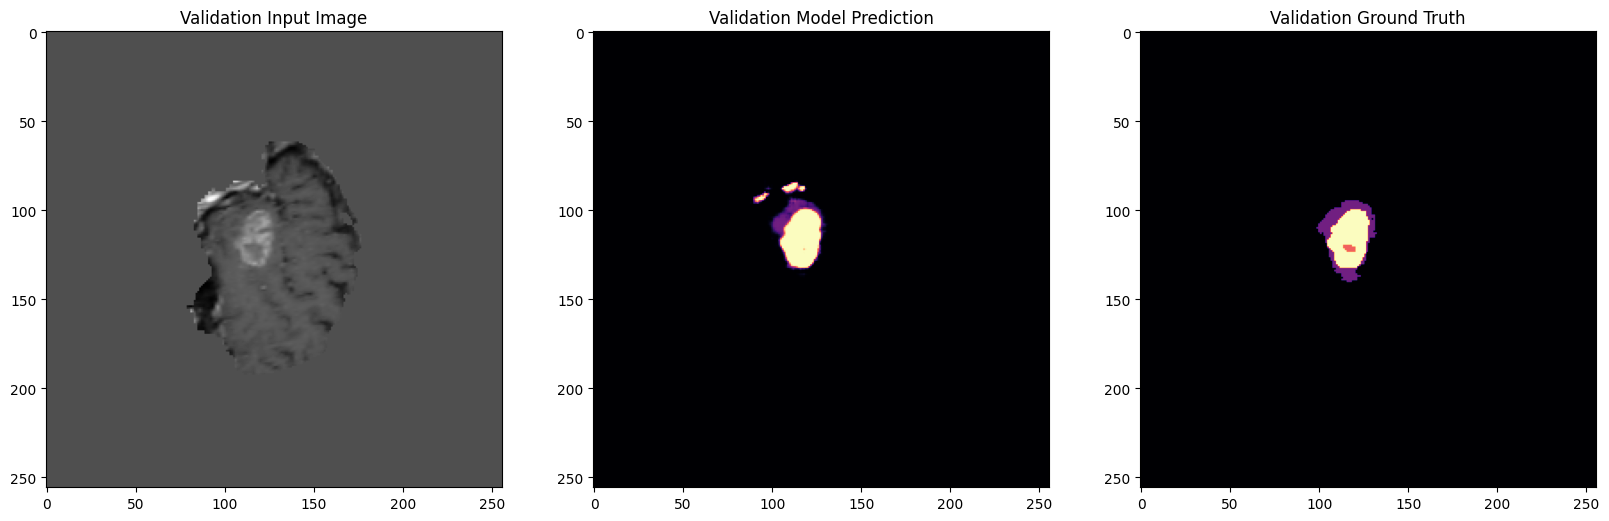

----------
epoch 31/50
epoch 31 average loss: 0.2084
current epoch: 31 train_set mean dice: 0.8594
time consuming of epoch 31 is: 41.6333
epoch 31 average validation loss: 0.2198
Current Learning Rate: 0.0038531818838573157


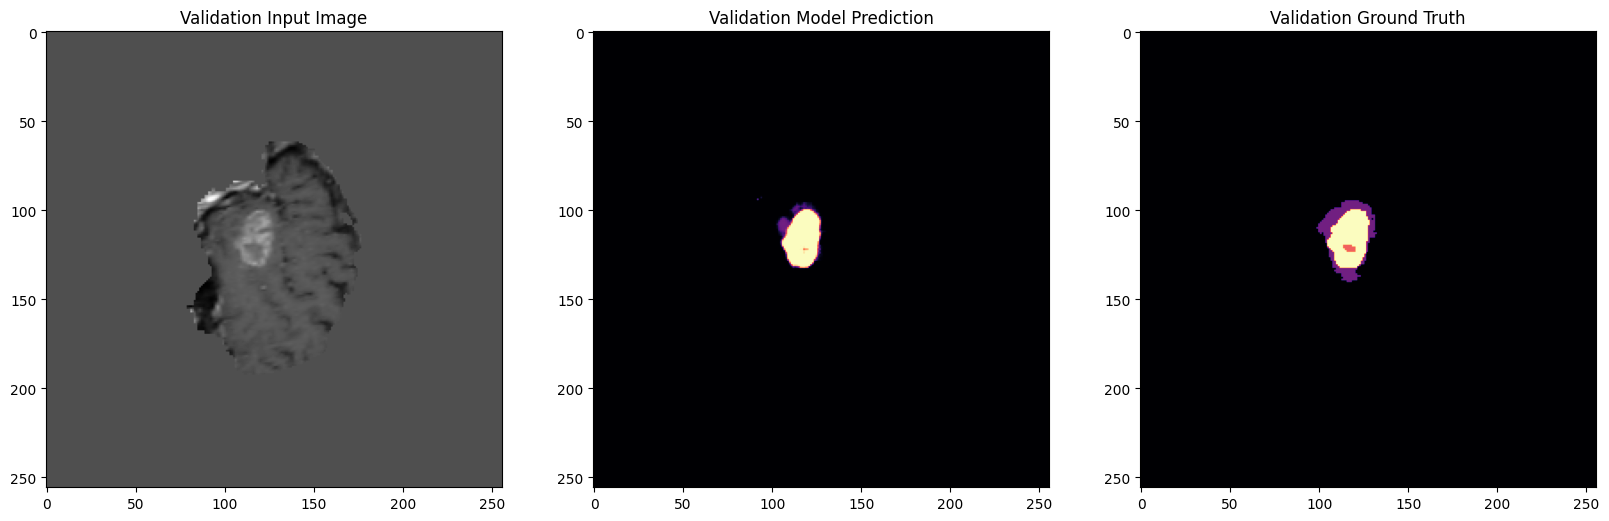

----------
epoch 32/50
epoch 32 average loss: 0.2034
current epoch: 32 train_set mean dice: 0.8622
time consuming of epoch 32 is: 41.4319
epoch 32 average validation loss: 0.2148
Current Learning Rate: 0.0038531818838573157


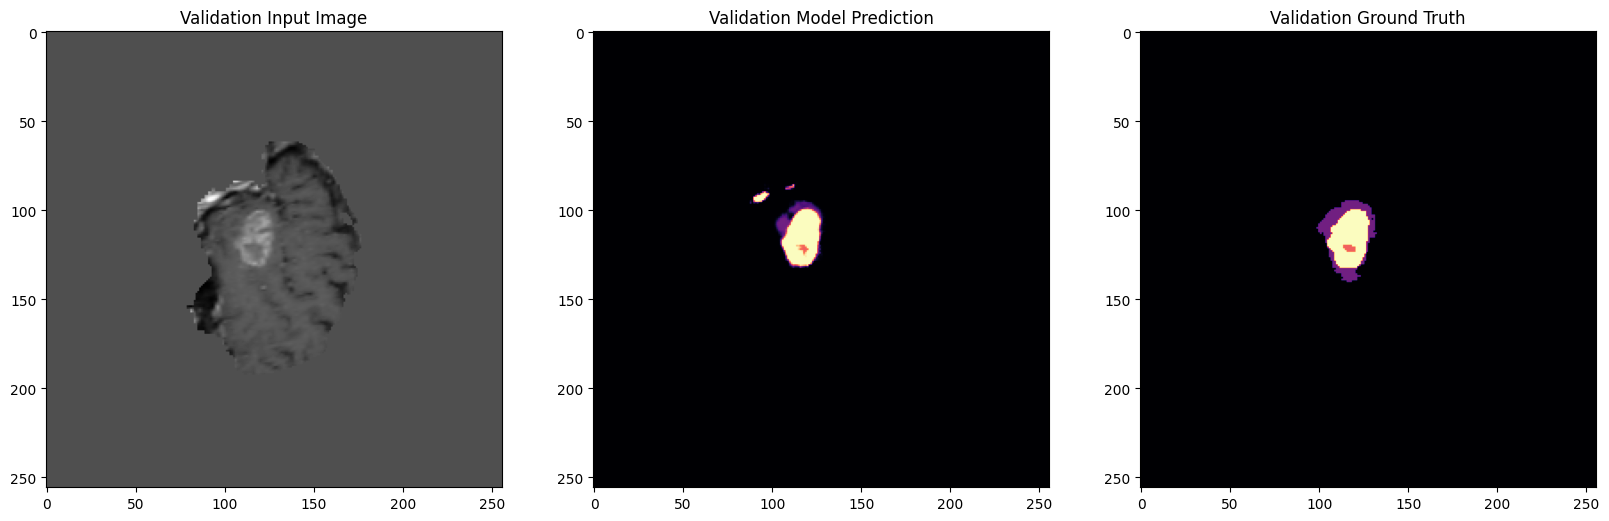

----------
epoch 33/50
epoch 33 average loss: 0.2001
current epoch: 33 train_set mean dice: 0.8672
time consuming of epoch 33 is: 41.8491
epoch 33 average validation loss: 0.2088
Best model saved with validation loss: 0.2088
Current Learning Rate: 0.0038531818838573157


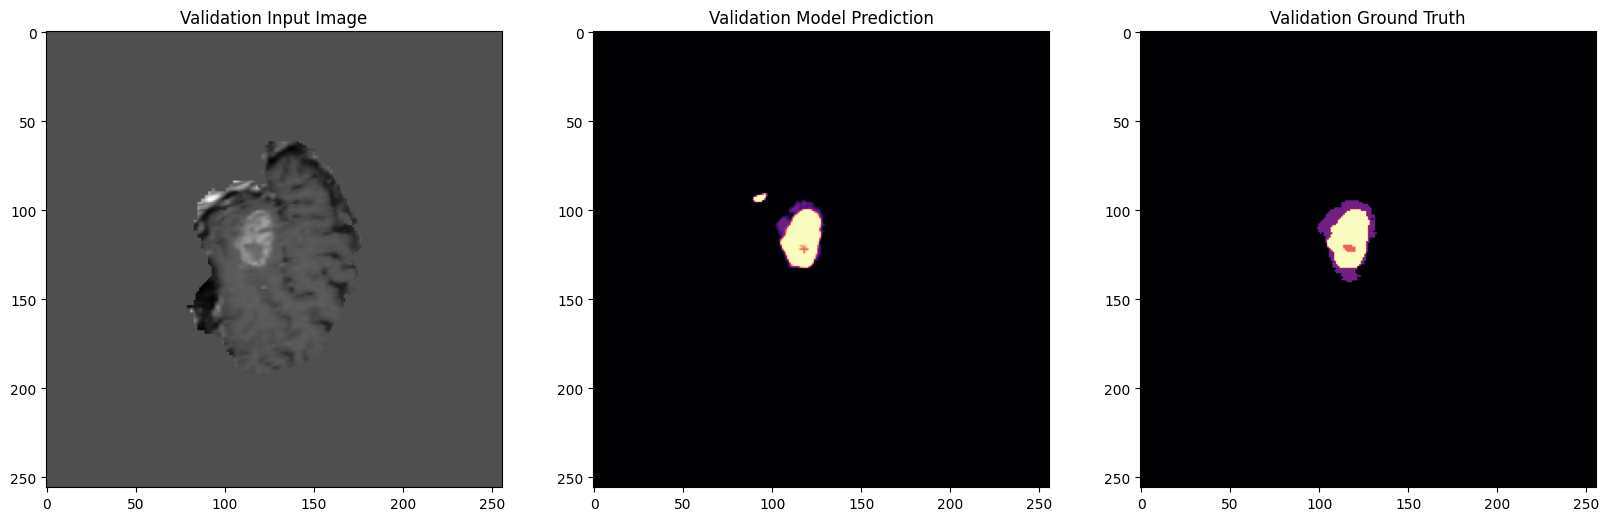

----------
epoch 34/50
epoch 34 average loss: 0.1978
current epoch: 34 train_set mean dice: 0.8687
time consuming of epoch 34 is: 43.8096
epoch 34 average validation loss: 0.2075
Best model saved with validation loss: 0.2075
Current Learning Rate: 0.0038531818838573157


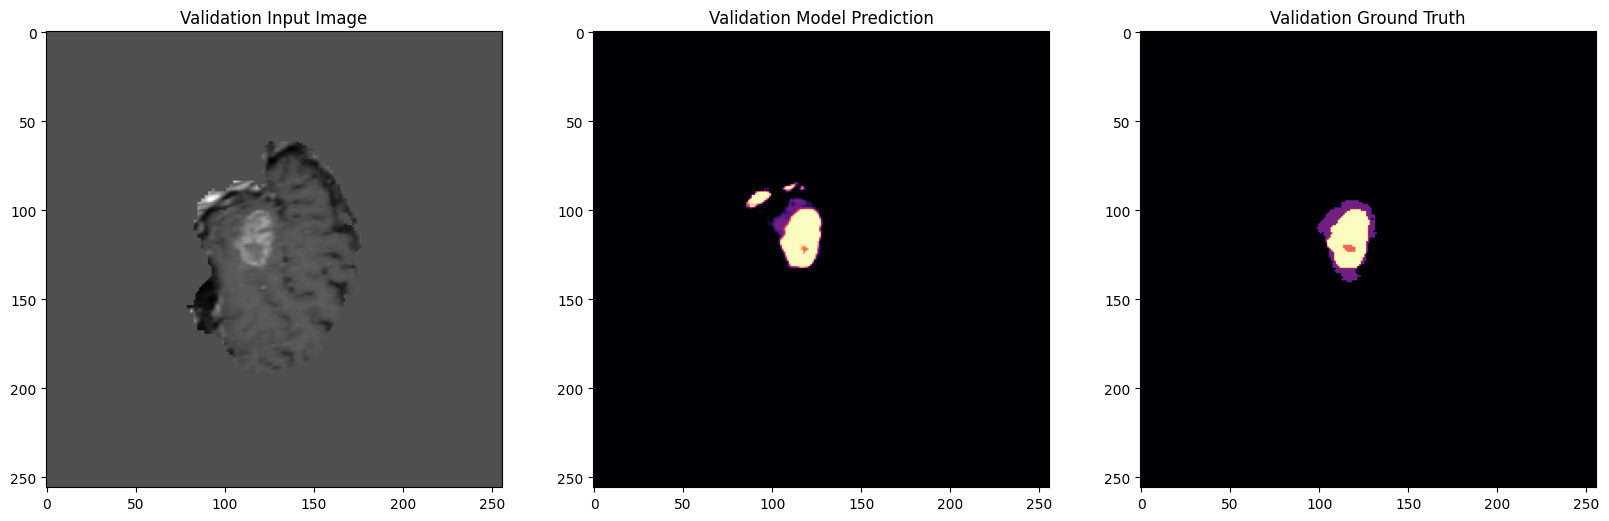

----------
epoch 35/50
epoch 35 average loss: 0.1978
current epoch: 35 train_set mean dice: 0.8689
time consuming of epoch 35 is: 44.2318
epoch 35 average validation loss: 0.2072
Best model saved with validation loss: 0.2072
Current Learning Rate: 0.0038531818838573157


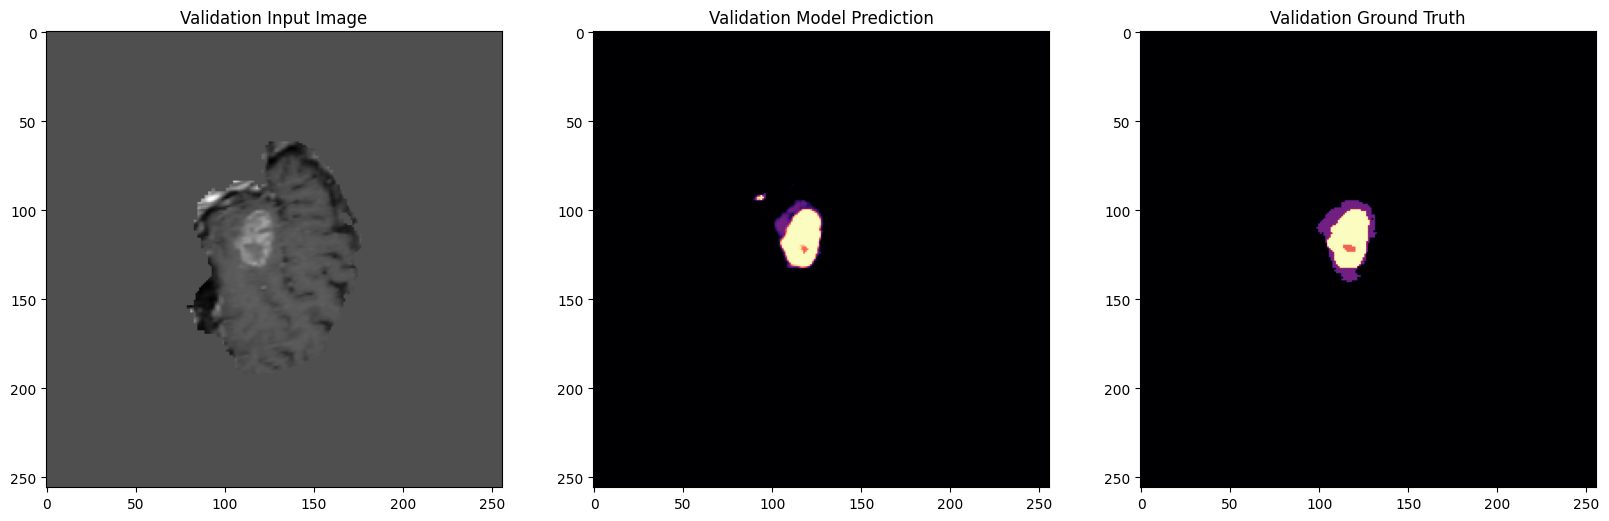

----------
epoch 36/50
epoch 36 average loss: 0.1951
current epoch: 36 train_set mean dice: 0.8722
time consuming of epoch 36 is: 43.4702
epoch 36 average validation loss: 0.2058
Best model saved with validation loss: 0.2058
Current Learning Rate: 0.0038531818838573157


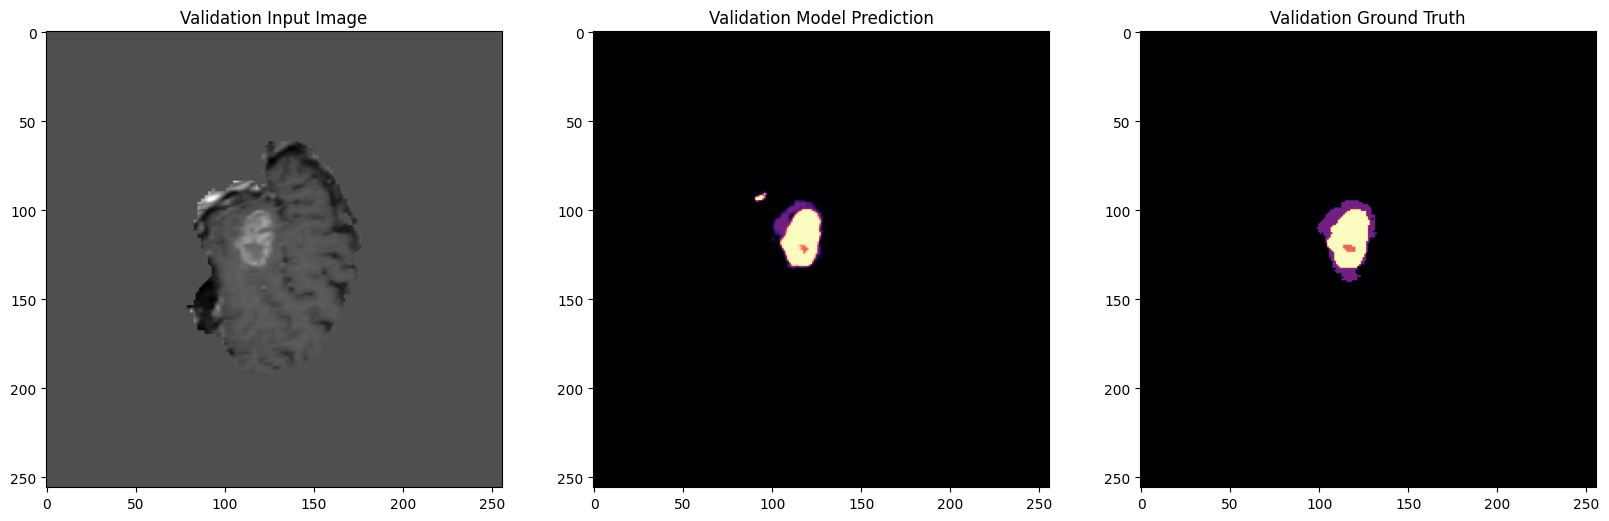

----------
epoch 37/50
epoch 37 average loss: 0.1918
current epoch: 37 train_set mean dice: 0.8756
time consuming of epoch 37 is: 43.1917
epoch 37 average validation loss: 0.2064
Current Learning Rate: 0.0038531818838573157


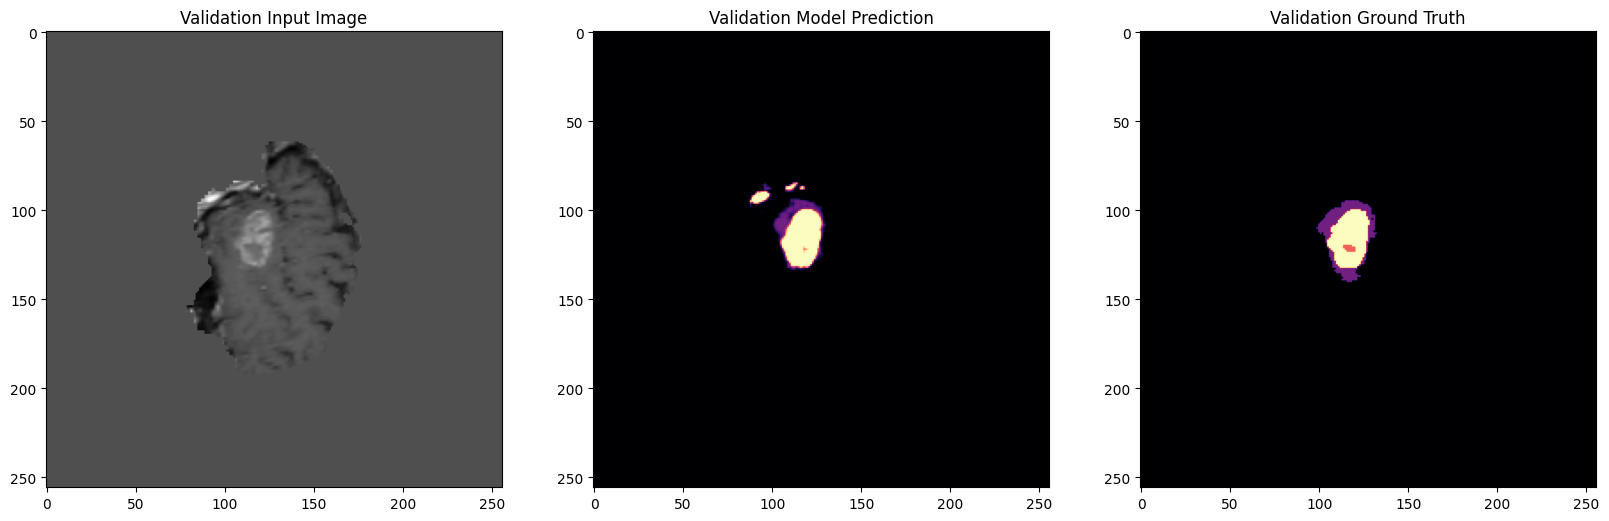

----------
epoch 38/50
epoch 38 average loss: 0.1938
current epoch: 38 train_set mean dice: 0.8735
time consuming of epoch 38 is: 42.7266
epoch 38 average validation loss: 0.2132
Current Learning Rate: 0.0038531818838573157


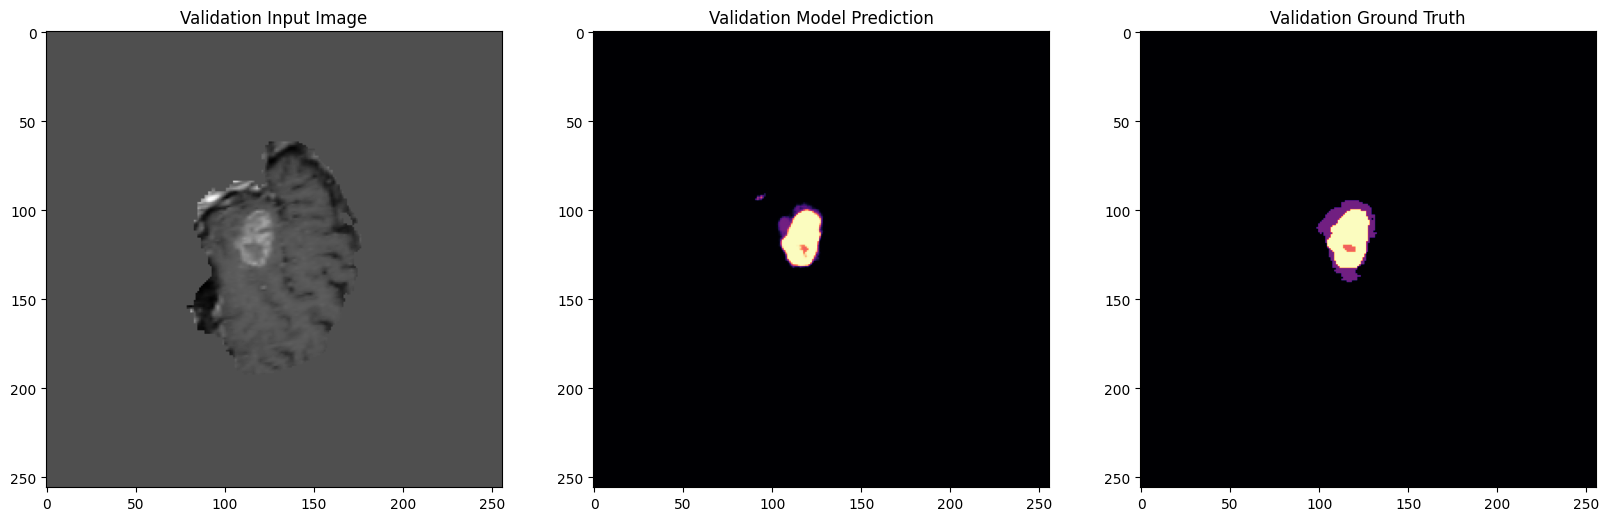

----------
epoch 39/50
epoch 39 average loss: 0.1927
current epoch: 39 train_set mean dice: 0.8742
time consuming of epoch 39 is: 42.8708
epoch 39 average validation loss: 0.2088
Current Learning Rate: 0.0038531818838573157


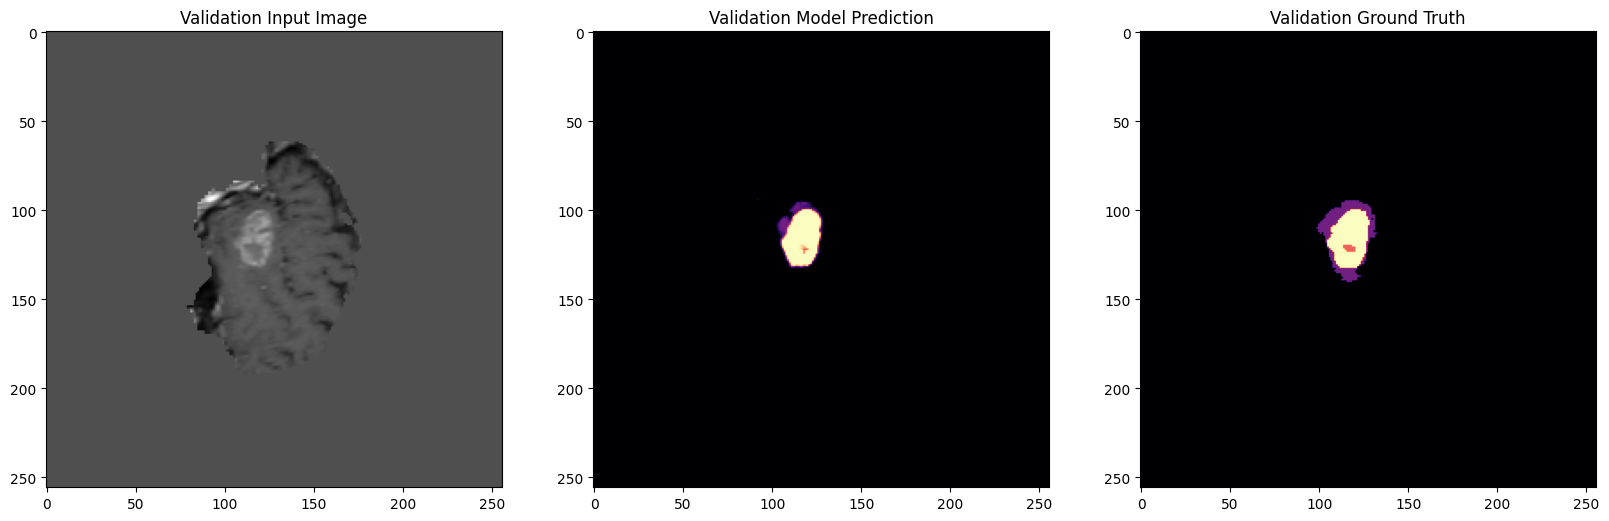

----------
epoch 40/50
epoch 40 average loss: 0.1880
current epoch: 40 train_set mean dice: 0.8767
time consuming of epoch 40 is: 43.0721
epoch 40 average validation loss: 0.2051
Best model saved with validation loss: 0.2051
Current Learning Rate: 0.0038531818838573157


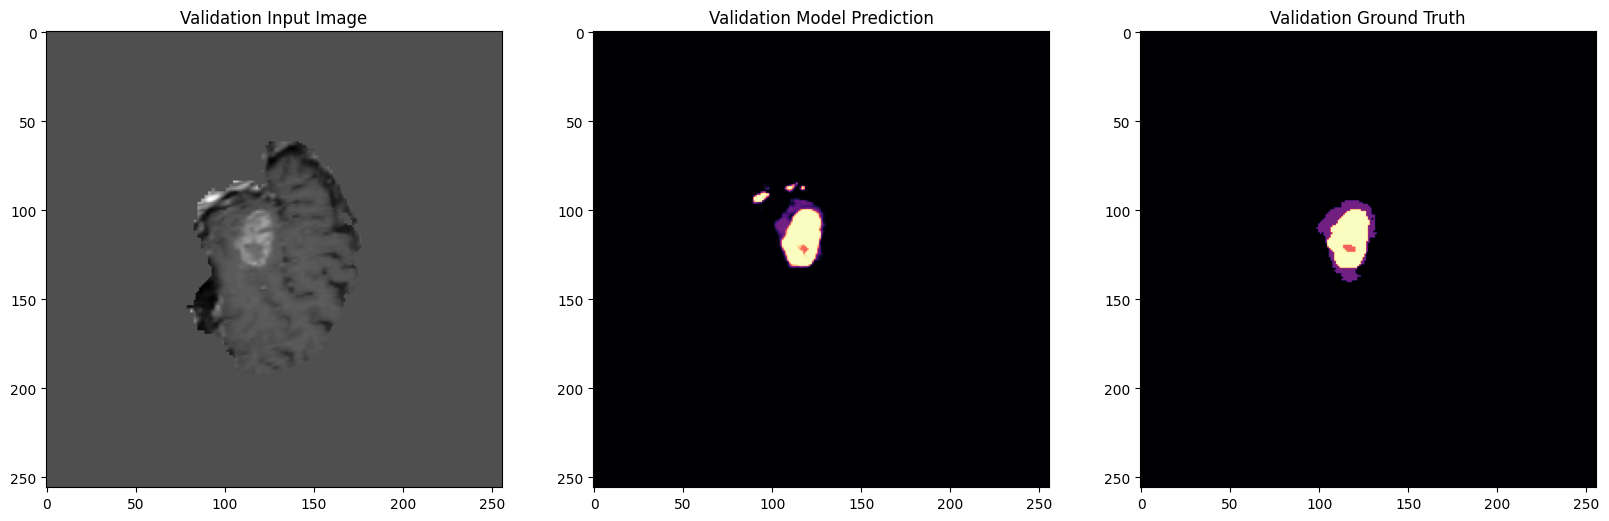

----------
epoch 41/50
epoch 41 average loss: 0.1886
current epoch: 41 train_set mean dice: 0.8781
time consuming of epoch 41 is: 41.6432
epoch 41 average validation loss: 0.2037
Best model saved with validation loss: 0.2037
Current Learning Rate: 0.0038531818838573157


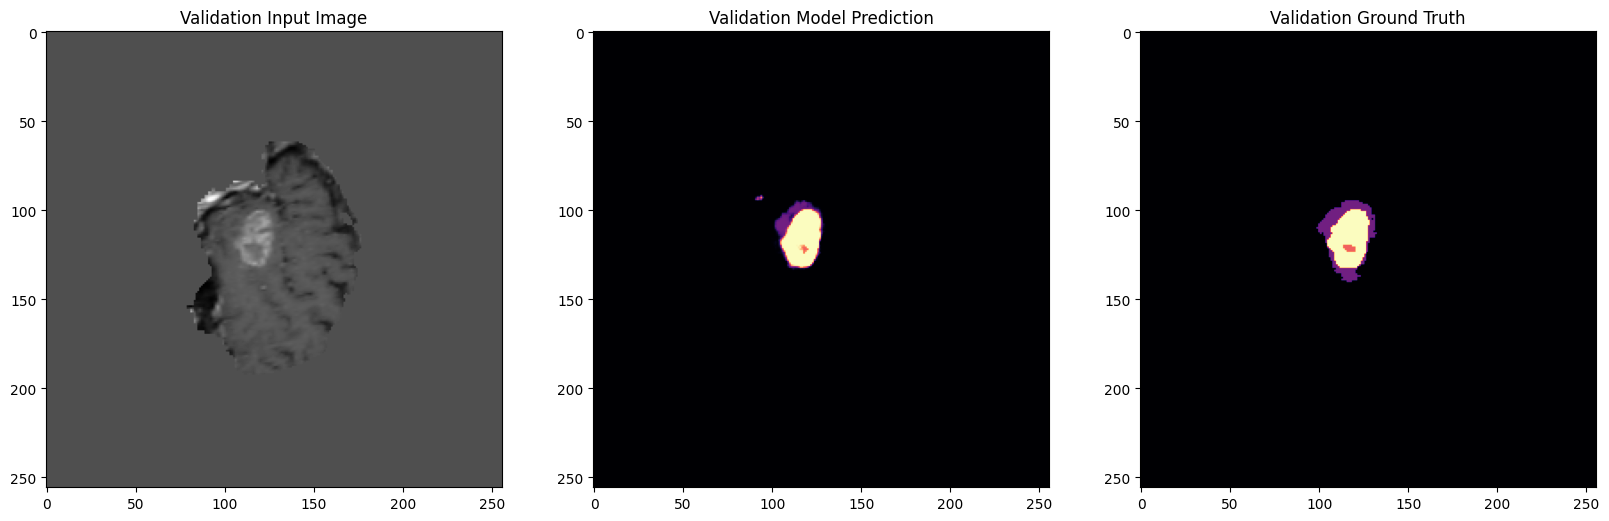

----------
epoch 42/50
epoch 42 average loss: 0.1883
current epoch: 42 train_set mean dice: 0.8766
time consuming of epoch 42 is: 41.1896
epoch 42 average validation loss: 0.2063
Current Learning Rate: 0.0038531818838573157


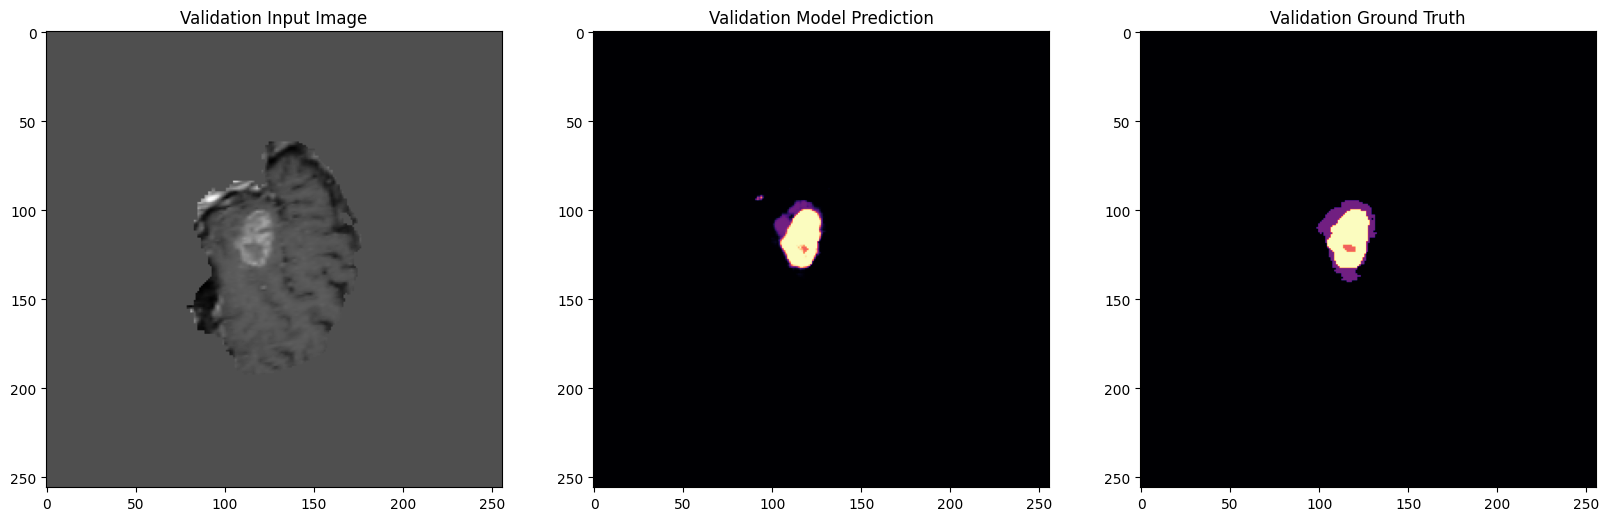

----------
epoch 43/50
epoch 43 average loss: 0.1873
current epoch: 43 train_set mean dice: 0.8806
time consuming of epoch 43 is: 41.3418
epoch 43 average validation loss: 0.2056
Current Learning Rate: 0.0038531818838573157


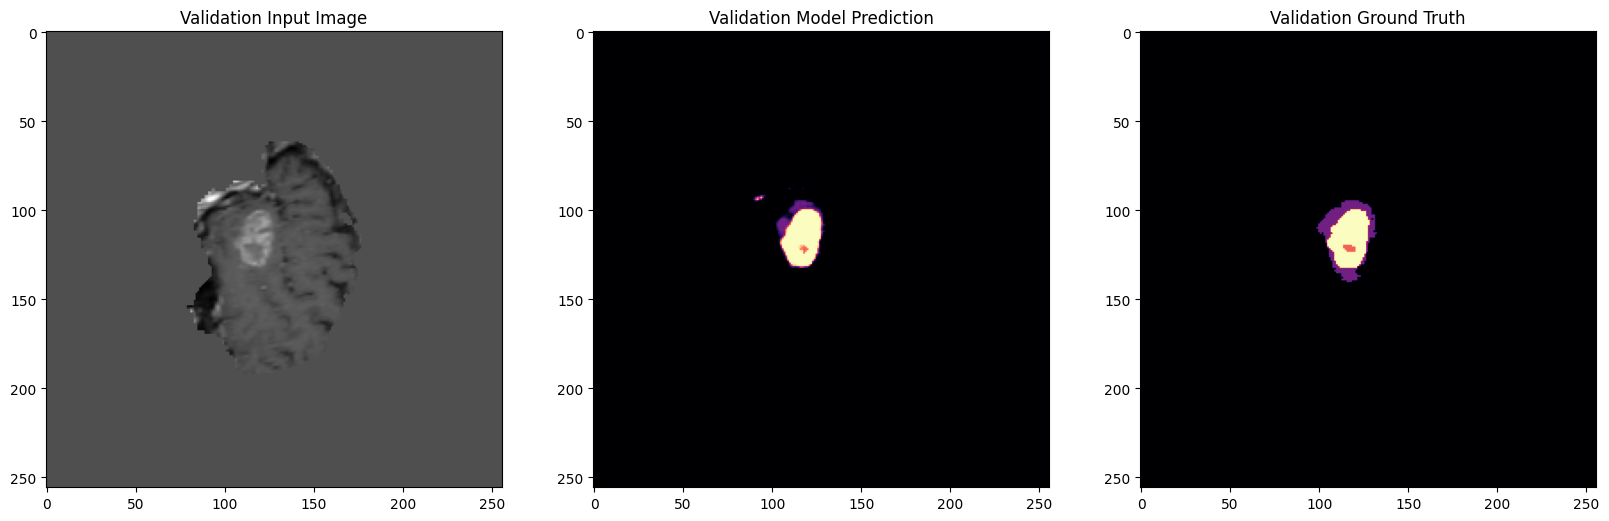

----------
epoch 44/50
epoch 44 average loss: 0.1841
current epoch: 44 train_set mean dice: 0.8811
time consuming of epoch 44 is: 41.5279
epoch 44 average validation loss: 0.2045
Current Learning Rate: 0.0038531818838573157


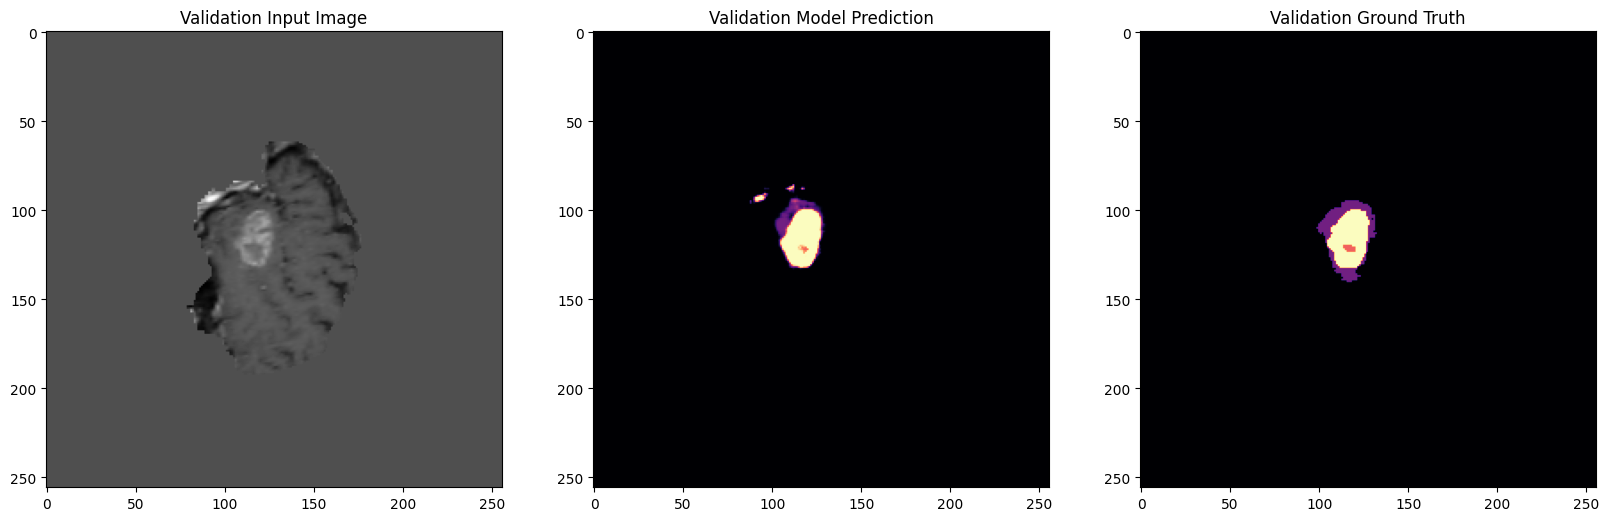

----------
epoch 45/50
epoch 45 average loss: 0.1878
current epoch: 45 train_set mean dice: 0.8793
time consuming of epoch 45 is: 40.4670
epoch 45 average validation loss: 0.2010
Best model saved with validation loss: 0.2010
Current Learning Rate: 0.0038531818838573157


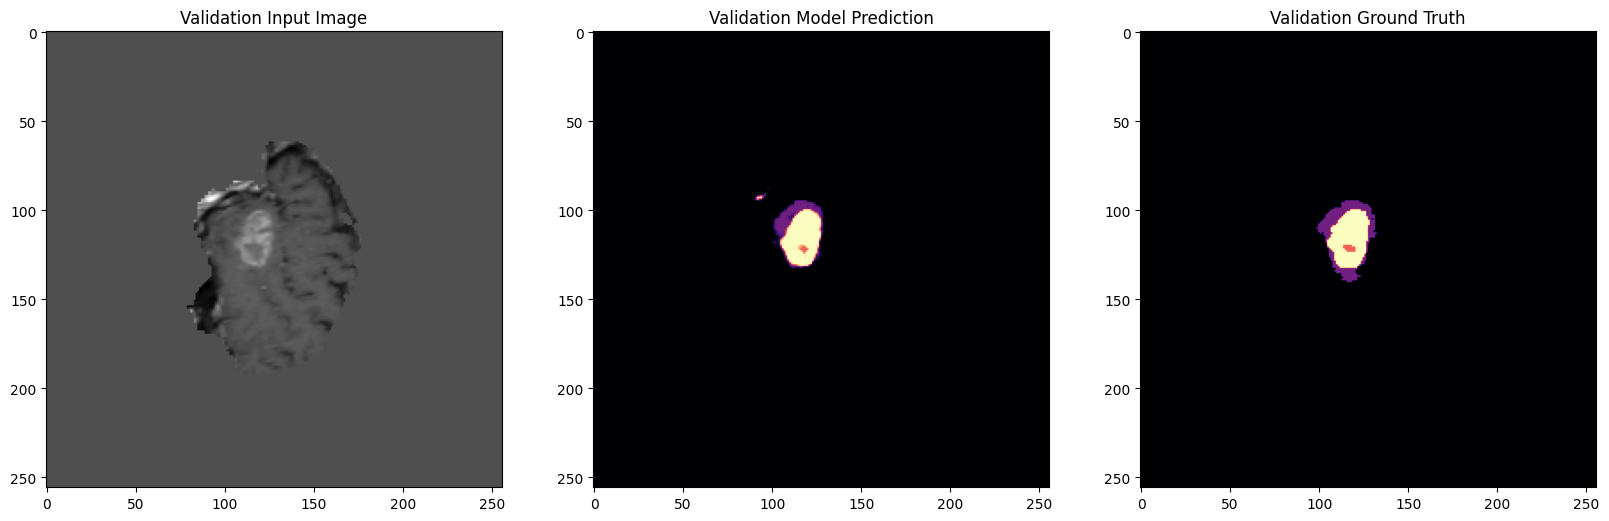

----------
epoch 46/50
epoch 46 average loss: 0.1846
current epoch: 46 train_set mean dice: 0.8820
time consuming of epoch 46 is: 41.9943
epoch 46 average validation loss: 0.2023
Current Learning Rate: 0.0038531818838573157


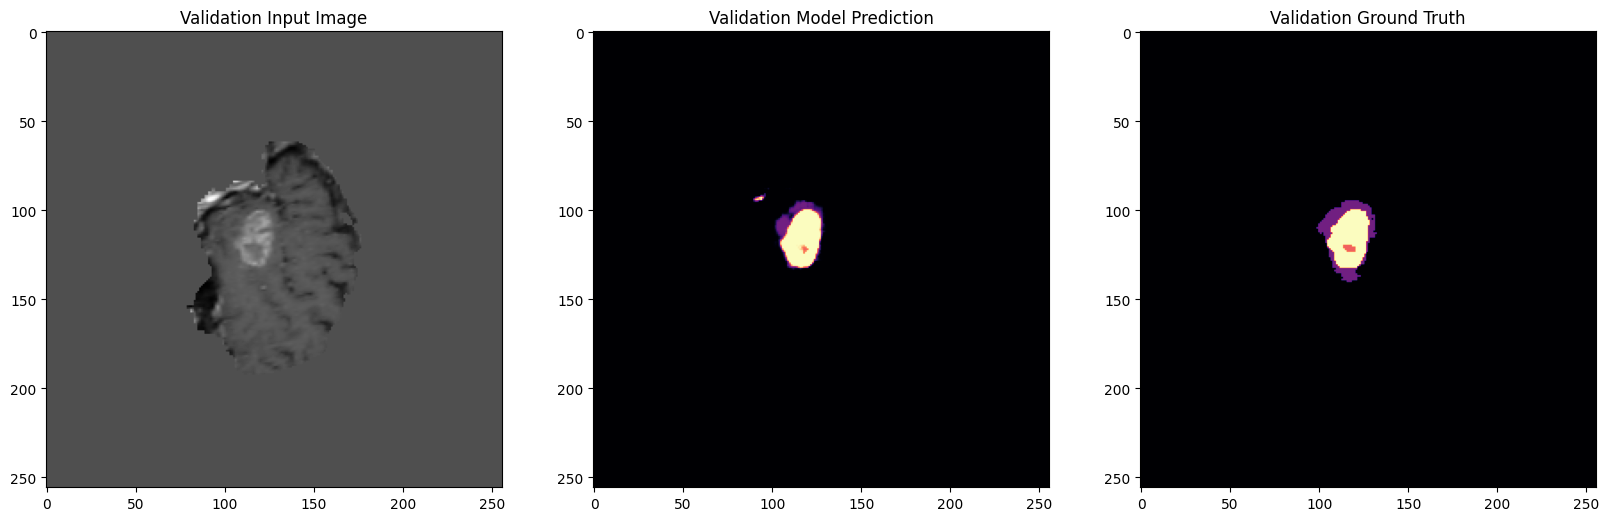

----------
epoch 47/50
epoch 47 average loss: 0.1818
current epoch: 47 train_set mean dice: 0.8835
time consuming of epoch 47 is: 43.7998
epoch 47 average validation loss: 0.2030
Current Learning Rate: 0.0038531818838573157


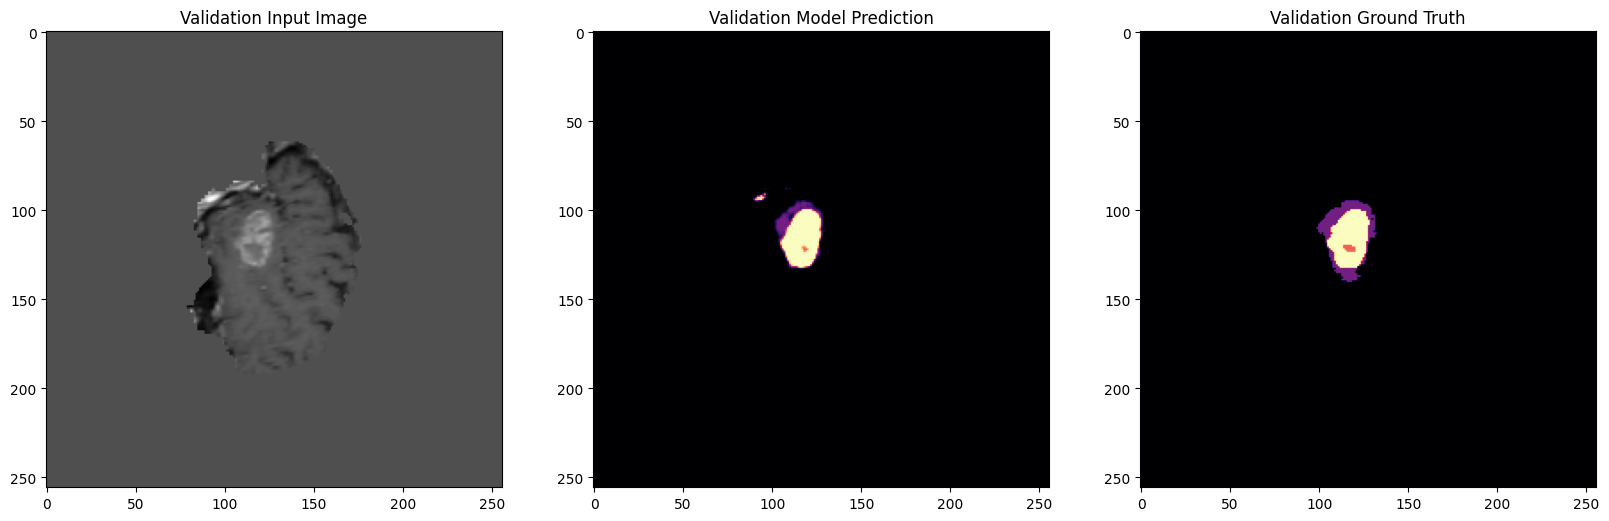

----------
epoch 48/50
epoch 48 average loss: 0.1804
current epoch: 48 train_set mean dice: 0.8822
time consuming of epoch 48 is: 42.7131
epoch 48 average validation loss: 0.2086
Current Learning Rate: 0.0038531818838573157


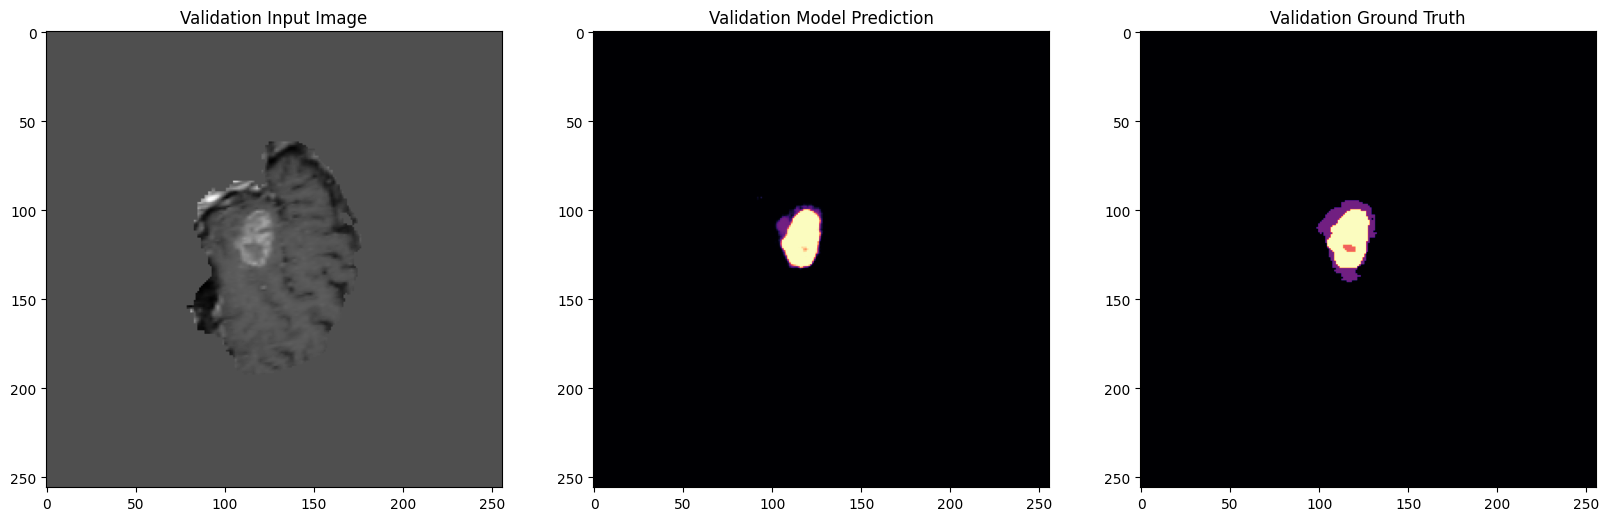

----------
epoch 49/50
epoch 49 average loss: 0.1819
current epoch: 49 train_set mean dice: 0.8842
time consuming of epoch 49 is: 44.6040
epoch 49 average validation loss: 0.2035
Current Learning Rate: 0.0038531818838573157


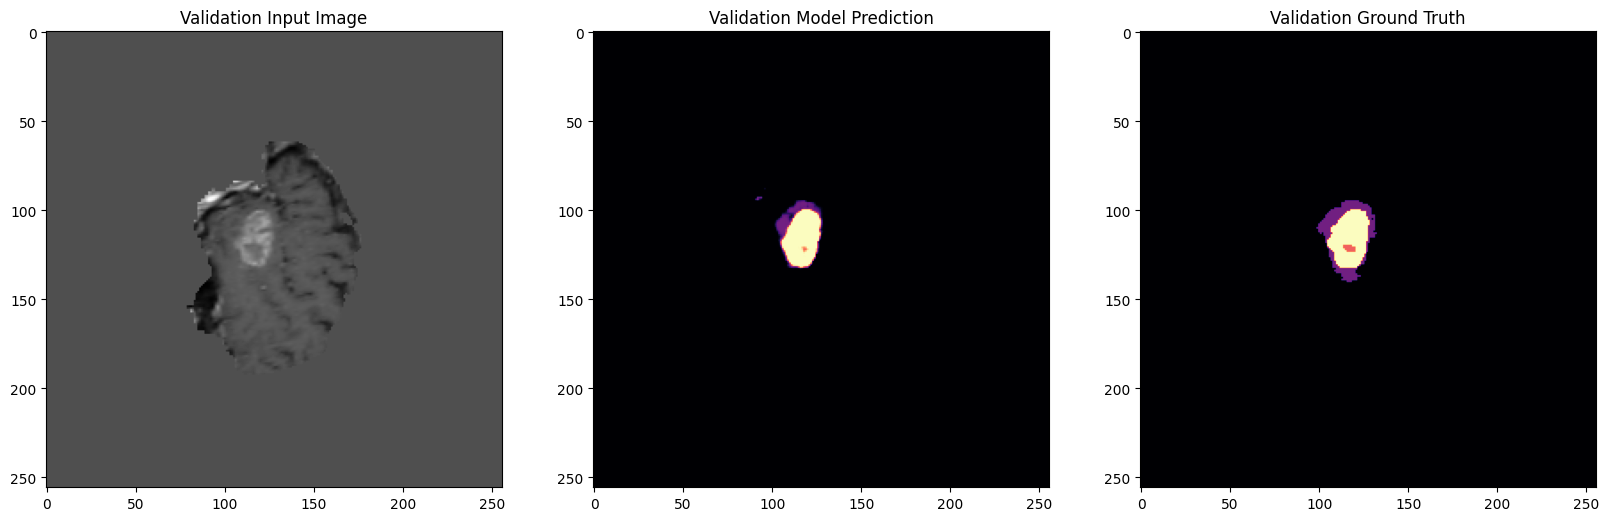

----------
epoch 50/50
epoch 50 average loss: 0.1825
current epoch: 50 train_set mean dice: 0.8812
time consuming of epoch 50 is: 43.4578
epoch 50 average validation loss: 0.2078
Current Learning Rate: 0.0038531818838573157


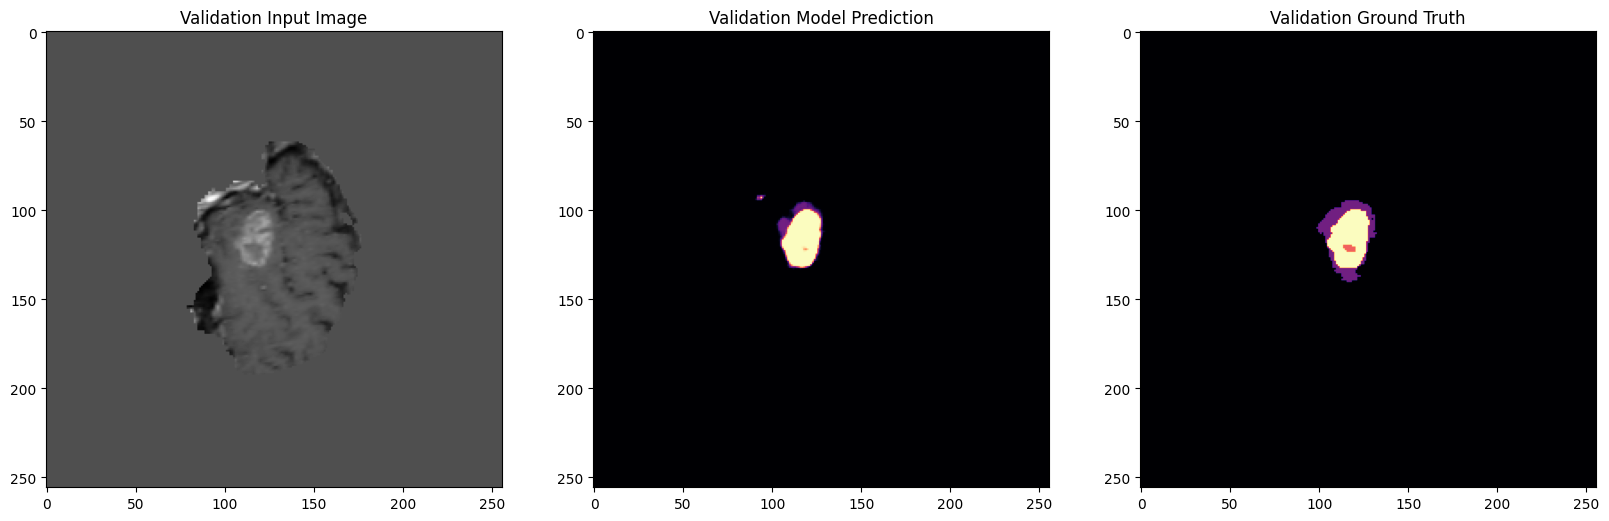

In [ ]:
import os
total_start = time.time()

# initialize lists for recording training history
epoch_loss_values = []
epoch_dice_scores = []
epoch_val_loss_values = []
best_val_loss = float('inf')  # Initialize the best validation loss to infinity

best_model_path = "/BestModel/best_model.pth"  # Path to save the best model
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    epoch_loss = 0
    steps = 0

    # count batch_index and load batch of images and labels
    for batch_idx, batch_data in enumerate(train_loader):
        step_start = time.time()
        steps += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["mask"].to(device),
        )
        # predict
        outputs = model(inputs)
        # compute loss based on predictions
        loss = loss_function(outputs, labels)
        # compute gradients
        loss.backward()
        # apply weight update based on gradients
        optimizer.step()
        # reset optimizer state for next batch update
        optimizer.zero_grad()

        # increase the loss for the current epoch
        epoch_loss += loss.item()

        # compute Dice score for current predictions
        outputs_ = torch.nn.functional.sigmoid(outputs.detach().clone())
        outputs_[outputs_>=0.5] = 1
        outputs_[outputs_<0.5] = 0
        dice_metric(y_pred=outputs_, y=labels)

    # compute average loss of this epoch and add to history
    epoch_loss /= steps
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # compute average Dice of this epoch and add to history
    metric = dice_metric.aggregate().item()
    epoch_dice_scores.append(metric)
    dice_metric.reset()
    print(f"current epoch: {epoch + 1} train_set mean dice: {metric:.4f}")

    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")


    # Validation phase
    model.eval()
    val_loss = 0
    val_steps = 0
    with torch.no_grad():
        for val_batch_data in val_loader:
            val_steps += 1
            val_inputs = val_batch_data["image"].to(device)
            val_labels = val_batch_data["mask"].to(device)

            # Forward pass
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels).item()

    # Compute average validation loss for the epoch
    val_loss /= val_steps
    epoch_val_loss_values.append(val_loss)
    print(f"epoch {epoch + 1} average validation loss: {val_loss:.4f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")


    # Scheduler step based on validation loss
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr}")


    # Get the first sample in the batch
    val_brain_img = val_inputs[0].detach().cpu()
    val_mask_img = val_labels[0].detach().cpu()
    val_mask_out = torch.nn.functional.sigmoid(val_outputs[0].detach().cpu())

    # Plot results
    plt.figure(figsize=(20, 10))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Validation Input Image")
    plt.imshow(val_brain_img[0], cmap="Greys_r")

    # Model prediction
    plt.subplot(1, 3, 2)
    plt.title("Validation Model Prediction")
    val_mask_out = val_mask_out.permute(1, 2, 0).sum(axis=-1)
    plt.imshow(val_mask_out, cmap="magma")

    # Ground truth
    plt.subplot(1, 3, 3)
    plt.title("Validation Ground Truth")
    val_mask_img = val_mask_img.permute(1, 2, 0).sum(axis=-1)
    plt.imshow(val_mask_img, cmap="magma")

    plt.show()
    plt.close()


    model.train()

total_time = time.time() - total_start

## Model History

### Original work
This code plots the training loss history over epochs, providing a visual representation of how the loss decreases during training.

### Changes performed

Added a plot for validation loss alongside training loss to compare their progression over epochs.

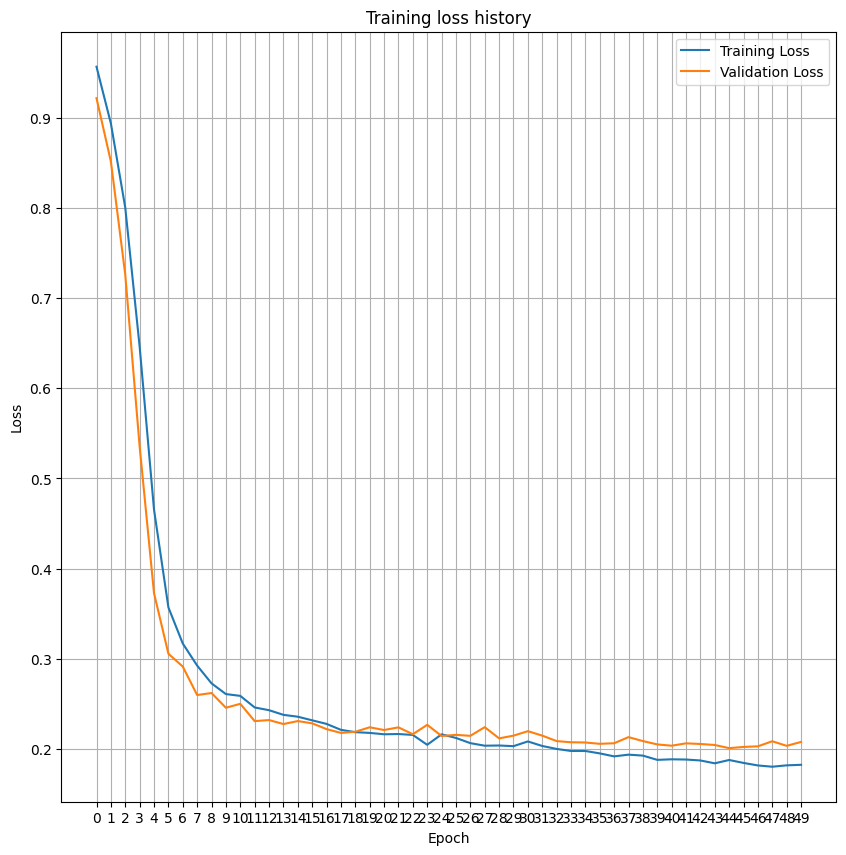

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(epoch_loss_values)
plt.plot(epoch_val_loss_values)
plt.legend(["Training Loss","Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([i for i in range(max_epochs)])
plt.title("Training loss history")
plt.grid()
plt.show()
plt.close()

## Evaluation on Test set

### Changes performed
Introduced a test phase to evaluate the model on unseen data, calculating metrics like Dice score, IoU, precision, and recall. Visualized test predictions alongside ground truth for qualitative assessment.
Included a bar plot in the next block to visualize these metrics.

<ipython-input-36-9ad24c7d4617>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Loss: 0.2182
Dice metric: 0.8540
Intersection over Union (IoU): 0.8021
Precision: 0.8695
Recall: 0.9053


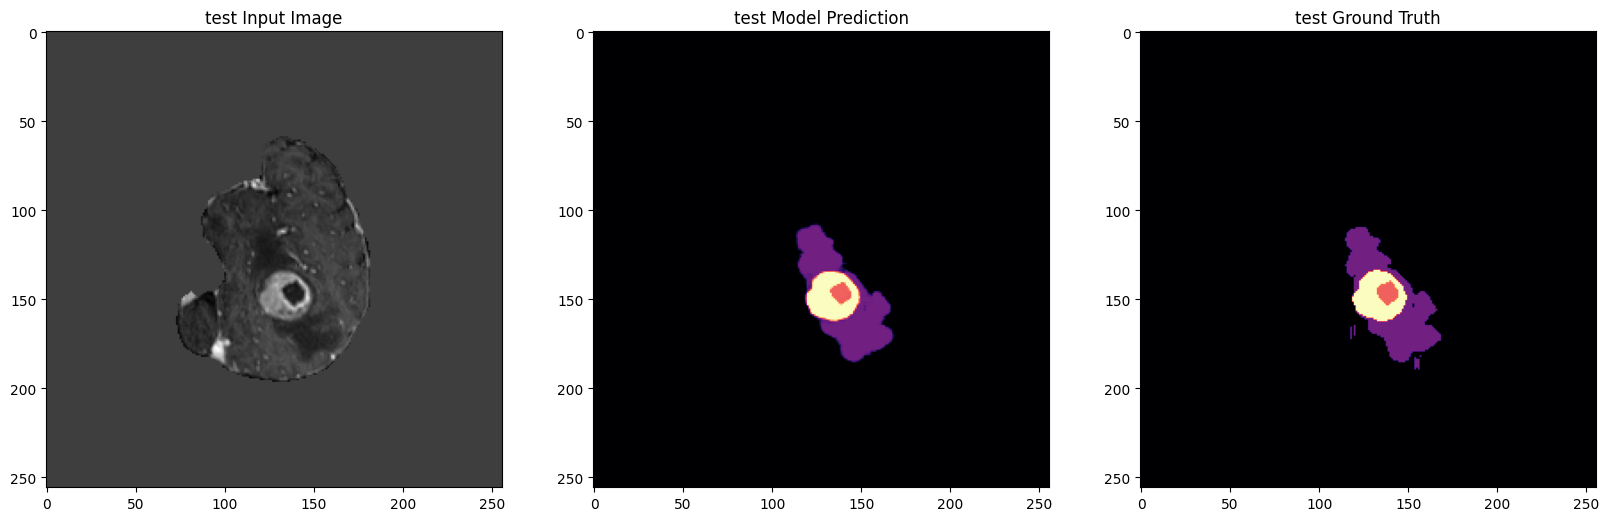

In [ ]:
from monai.metrics import DiceMetric
from sklearn.metrics import precision_score, recall_score, jaccard_score



# Initialize the Dice Metric (MONAI)
dice_metric = DiceMetric(include_background=True, reduction="mean")

# Initialize metric accumulators
dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []



# Test Loop
best_model_path = "/BestModel/best_model.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode
test_loss = 0
test_steps = 0

with torch.no_grad():
    for test_batch_data in test_loader:
        test_steps += 1
        test_inputs = test_batch_data["image"].to(device)
        test_labels = test_batch_data["mask"].to(device)

        # Forward pass
        test_outputs = model(test_inputs)

        # Compute loss
        test_loss += loss_function(test_outputs, test_labels).item()


        test_outputs_ = torch.nn.functional.sigmoid(test_outputs.detach().clone())
        test_outputs_[test_outputs_>=0.5] = 1
        test_outputs_[test_outputs_<0.5] = 0

        # Post-process outputs
        test_preds = test_outputs_

        # Update Dice Metric
        dice_metric(y_pred=test_outputs_, y=test_labels)

        # Flatten for metric calculations
        test_preds_np = test_preds.cpu().numpy().flatten()
        test_labels_np = test_labels.cpu().numpy().flatten()

        # Compute Metrics
        iou = jaccard_score(test_labels_np, test_preds_np, average="binary")
        iou_scores.append(iou)

        precision = precision_score(test_labels_np, test_preds_np, zero_division=0)
        precision_scores.append(precision)

        recall = recall_score(test_labels_np, test_preds_np, zero_division=0)
        recall_scores.append(recall)


# Calculate average metrics
avg_test_loss = test_loss / test_steps
avg_dice = dice_metric.aggregate().item()
avg_iou = sum(iou_scores) / len(iou_scores)
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)


# Print results
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Dice metric: {avg_dice:.4f}")
print(f"Intersection over Union (IoU): {avg_iou:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")



# Get the first sample in the batch
test_brain_img = test_inputs[0].detach().cpu()
test_mask_img = test_labels[0].detach().cpu()
test_mask_out = torch.nn.functional.sigmoid(test_outputs[0].detach().cpu())

# Plot results
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(1, 3, 1)
plt.title("test Input Image")
plt.imshow(test_brain_img[0], cmap="Greys_r")

# Model prediction
plt.subplot(1, 3, 2)
plt.title("test Model Prediction")
test_mask_out = test_mask_out.permute(1, 2, 0).sum(axis=-1)
plt.imshow(test_mask_out, cmap="magma")

# Ground truth
plt.subplot(1, 3, 3)
plt.title("test Ground Truth")
test_mask_img = test_mask_img.permute(1, 2, 0).sum(axis=-1)
plt.imshow(test_mask_img, cmap="magma")

plt.show()
plt.close()

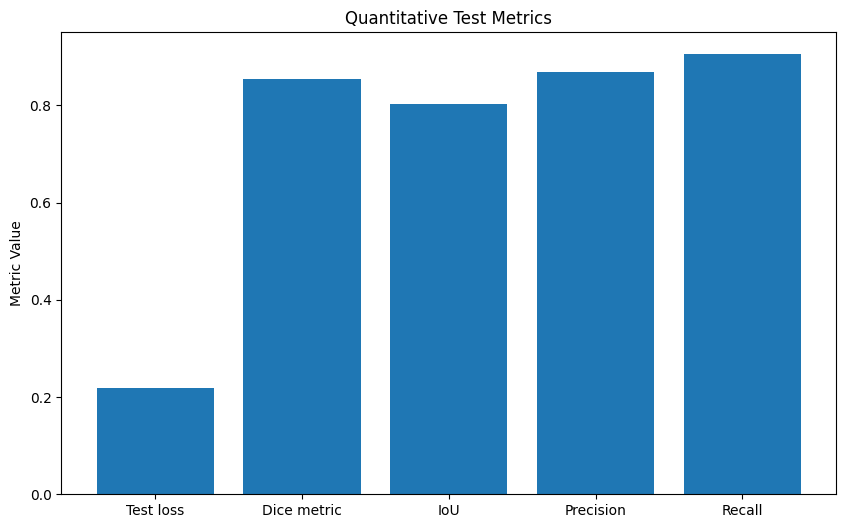

In [ ]:
plt.figure(figsize=(10, 6))
metrics = [avg_test_loss,avg_dice, avg_iou, avg_precision, avg_recall]
metric_names = ["Test loss","Dice metric", "IoU", "Precision", "Recall"]

plt.bar(metric_names, metrics)
plt.ylabel("Metric Value")
plt.title("Quantitative Test Metrics")
plt.show()


## Code to implement all slices together

In [ ]:
'''
Generate_split_data including all the slices at the same moment.
CAREFULL!!!!!
You have to adapt the code, e.g. put the new names where necessary and set the mask you want to segment in the training loop.

def generate_split_data(subjects):
  brains_t1ce_t_00 = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt1ce_PLANE{'00'}.npy" for subject in subjects_ID_list]
  brains_flair_t_00 = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYflair_PLANE{'00'}.npy" for subject in subjects_ID_list]
  masks_t_00 = [TRAIN_PATH+f"SUBJECT{subject}_MASK_PLANE{'00'}.npy" for subject in subjects_ID_list]

  brains_t1ce_t_01 = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt1ce_PLANE{'01'}.npy" for subject in subjects_ID_list]
  brains_flair_t_01 = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYflair_PLANE{'01'}.npy" for subject in subjects_ID_list]
  masks_t_01 = [TRAIN_PATH+f"SUBJECT{subject}_MASK_PLANE{'01'}.npy" for subject in subjects_ID_list]

  brains_t1ce_t_10 = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt1ce_PLANE{'10'}.npy" for subject in subjects_ID_list]
  brains_flair_t_10 = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYflair_PLANE{'10'}.npy" for subject in subjects_ID_list]
  masks_t_10 = [TRAIN_PATH+f"SUBJECT{subject}_MASK_PLANE{'10'}.npy" for subject in subjects_ID_list]


  return [
      {
          "image_t1ce_00": brain_t1ce_00,
          "image_flair_00": brain_flair_00,
          "mask_00": mask_00,
          "image_t1ce_01": brain_t1ce_01,
          "image_flair_01": brain_flair_01,
          "mask_01": mask_01,
          "image_t1ce_10": brain_t1ce_10,
          "image_flair_10": brain_flair_10,
          "mask_10": mask_10,
      }
      for brain_t1ce_00, brain_flair_00, mask_00, brain_t1ce_01, brain_flair_01, mask_01, brain_t1ce_10, brain_flair_10, mask_10,  in zip(
        brains_t1ce_t_00, brains_flair_t_00, masks_t_00, brains_t1ce_t_01, brains_flair_t_01, masks_t_01, brains_t1ce_t_10, brains_flair_t_10, masks_t_10
      )
  ]

  modality_keys = ["image_t1ce_00", "image_flair_00", "image_t1ce_01", "image_flair_01", "image_t1ce_10", "image_flair_10"]


'''

' \nGenerate_split_data including all the slices at the same moment.  \nCAREFULL!!!!!\nTakes all slices\nTo adapt to the code you have to change the number of input channels in the UNET.\nChange also in CropForegroundd the image relative to the slice considered in that moment.\nChange in the training which mask you want to segment. \n\ndef generate_split_data(subjects):\n  brains_t1ce_t_00 = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt1ce_PLANE{\'00\'}.npy" for subject in subjects_ID_list]\n  brains_flair_t_00 = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYflair_PLANE{\'00\'}.npy" for subject in subjects_ID_list]\n  masks_t_00 = [TRAIN_PATH+f"SUBJECT{subject}_MASK_PLANE{\'00\'}.npy" for subject in subjects_ID_list]\n\n  brains_t1ce_t_01 = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt1ce_PLANE{\'01\'}.npy" for subject in subjects_ID_list]\n  brains_flair_t_01 = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYflair_PLANE{\'01\'}.npy" for subject in subjects_ID_list]\n  masks_t_01 = [TRAIN_PATH+f"SUBJECT{subject